In [46]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from collections import Counter
from statsmodels.stats.outliers_influence import variance_inflation_factor

# INITIALISATION

## IMPORT DATA

In [2]:
DATA_PATH = "data/"

In [3]:
data = pd.read_csv(DATA_PATH + 'dpe-v2-logements-existants_Q4-24.csv')
data.head()

/var/folders/j2/kbgz9r7j3px3kmp5xj7y8sdc0000gn/T/ipykernel_794/3934816156.py:1: DtypeWarning: Columns (11,102,112,190,191,192,193,226,237) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(DATA_PATH + 'dpe-v2-logements-existants_Q4-24.csv')


,N°DPE,Date_réception_DPE,Date_établissement_DPE,Date_visite_diagnostiqueur,Modèle_DPE,N°_DPE_remplacé,Date_fin_validité_DPE,Version_DPE,N°_DPE_immeuble_associé,Appartement_non_visité_(0/1),...,Type_générateur_froid,Surface_climatisée,Type_énergie_climatisation,Catégorie_ENR,Electricité_PV_autoconsommée,Système_production_électricité_origine_renouvelable,Présence_production_PV_(0/1),Production_électricité_PV_(kWhep/an),Surface_totale_capteurs_photovoltaïque,Nombre_module
0,2427E4057431F,2024-11-18,2024-11-17,2024-11-17,DPE 3CL 2021 méthode logement,NaN,2034-11-16,2.4,NaN,NaN,...,NaN,NaN,NaN,panneaux solaires photovoltaïques,NaN,Solaire Photovoltaïque,1.0,10416.9,28.8,24.0
1,2462E3922466P,2024-11-06,2024-11-05,2024-10-30,DPE 3CL 2021 méthode logement,NaN,2034-11-04,2.4,NaN,NaN,...,NaN,NaN,NaN,panneaux solaires photovoltaïques,NaN,Solaire Photovoltaïque,1.0,4683.3,10.8,9.0
2,2481E3633888E,2024-10-16,2024-10-15,2024-10-10,DPE 3CL 2021 méthode logement,NaN,2034-10-14,2.4,NaN,NaN,...,PAC air/air installée entre 2008 et 2014,65.5,Électricité,Il existe plusieurs descriptifs ENR,NaN,Solaire Photovoltaïque,1.0,4658.2,16.0,1.0
3,2433E3834950M,2024-10-30,2024-10-29,2024-10-21,DPE 3CL 2021 méthode logement,2333E1163577I,2034-10-28,2.4,NaN,NaN,...,PAC air/air installée avant 2008,285.0,Électricité,Il existe plusieurs descriptifs ENR,NaN,Solaire Photovoltaïque,1.0,11223.0,24.0,20.0
4,2464E3951206B,2024-11-08,2024-11-07,2024-11-06,DPE 3CL 2021 méthode logement,NaN,2034-11-06,2.4,NaN,NaN,...,NaN,NaN,NaN,panneaux solaires photovoltaïques,NaN,Solaire Photovoltaïque,1.0,7628.7,16.8,14.0


## EXPLORATION VARIABLE CIBLE

In [4]:
data.rename(columns={"Conso_5_usages/m²_é_finale": "conso_nrj_m2_par_an"}, inplace=True)

In [5]:
y = data["conso_nrj_m2_par_an"]
y.head(10)

0    216.0
1     73.0
2    137.8
3     56.0
4    136.0
5     52.0
6     52.0
7     58.0
8     47.0
9    220.0
Name: conso_nrj_m2_par_an, dtype: float64

In [6]:
y.describe()

count    129597.000000
mean        163.188868
std         100.106938
min           6.000000
25%          95.000000
50%         137.000000
75%         210.000000
max        2636.000000
Name: conso_nrj_m2_par_an, dtype: float64

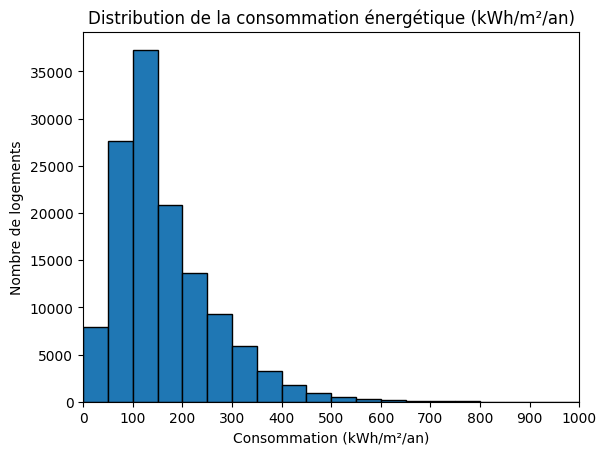

In [7]:
# Visu de la consommation moyenne des Français par m2/an (161 kWh en 2022)
plt.hist(y.dropna(), bins=range(0, 1050, 50), edgecolor="k")
plt.title("Distribution de la consommation énergétique (kWh/m²/an)")
plt.xlabel("Consommation (kWh/m²/an)")
plt.ylabel("Nombre de logements")
plt.xlim(0, 1000)
plt.xticks(range(0, 1100, 100))
plt.show()

## EDA GENERAL (CODE MATHIEU)

### TYPE OF DATA

In [8]:
"""
On classe les colonnes en fonction de leur type
"""

data_type = data

column_classification = {
    "Quantitative_Continues": [],
    "Quantitative_Discretes": [],
    "Qualitative_Nominales": [],
    "Qualitative_Ordinales": [],
    "Binaires": [],
    "Dates": []
}

# Ensembles de référence pour détecter les colonnes ordinales
known_ordinal_sets = [
    ['A', 'B', 'C', 'D', 'E', 'F', 'G'],
    ['faible', 'moyen', 'élevé'],
    ['insuffisante', 'moyenne', 'bonne'],
    ['Lourde', 'Moyenne', 'Légère']
]

# Parcourir les colonnes pour les classifier automatiquement
for col in data_type.columns:
    # Ignorer les colonnes entièrement vides
    if data_type[col].isnull().all():
        continue
    
    unique_values = data_type[col].dropna().unique()
    num_unique = len(unique_values)

    # Vérifier si c'est une colonne binaire (0 ou 1 uniquement)
    if set(unique_values).issubset({0, 1}):
        column_classification["Binaires"].append(col)

    # Vérifier si c'est une colonne temporelle (date)
    elif pd.api.types.is_datetime64_any_dtype(data_type[col]) or "Date" in col or "Période" in col:
        column_classification["Dates"].append(col)

    # Vérifier si c'est une variable quantitative discrète ou continue
    elif pd.api.types.is_numeric_dtype(data_type[col]):
        # Vérifier si toutes les valeurs sont des entiers (même si float64)
        all_integers = all(float(val).is_integer() for val in unique_values)

        if num_unique < 10000 and all_integers:
            column_classification["Quantitative_Discretes"].append(col)
        else:
            column_classification["Quantitative_Continues"].append(col)

    # Vérifier si c'est une variable qualitative ordinale
    elif pd.api.types.is_string_dtype(data_type[col]) or num_unique < 50:  # Heuristique pour catégorisation
        # Vérifier si toutes les valeurs uniques sont dans un ensemble de référence
        is_ordinal = False
        for ordinal_set in known_ordinal_sets:
            if any(val in ordinal_set for val in unique_values):
                column_classification["Qualitative_Ordinales"].append(col)
                is_ordinal = True
                break
        # Si ce n'est pas ordinale, l'ajouter comme nominale
        if not is_ordinal:
            column_classification["Qualitative_Nominales"].append(col)
    
    # Parcourir les colonnes restantes non classées
    classified_columns = (
        column_classification["Quantitative_Continues"] +
        column_classification["Quantitative_Discretes"] +
        column_classification["Qualitative_Nominales"] +
        column_classification["Qualitative_Ordinales"] +
        column_classification["Binaires"] +
        column_classification["Dates"]
    )

for col in data_type.columns:
    if col not in classified_columns:
        # Classer les colonnes non classées comme nominales
        column_classification["Qualitative_Nominales"].append(col)

# Afficher les résultats
for key, cols in column_classification.items():
    print(f"{key}:")
    for idx, col in enumerate(cols):
        col_index = data_type.columns.get_loc(col)
        print(f"  {col_index}: {col}")


Quantitative_Continues:
  7: Version_DPE
  21: Hauteur_sous-plafond
  26: Surface_habitable_logement
  40: Score_BAN
  42: Coordonnée_cartographique_X_(BAN)
  43: Coordonnée_cartographique_Y_(BAN)
  53: Conso_5_usages_é_finale
  54: conso_nrj_m2_par_an
  55: Conso_chauffage_é_finale
  56: Conso_chauffage_dépensier_é_finale
  57: Conso_éclairage_é_finale
  58: Conso_ECS_é_finale
  59: Conso_ECS_dépensier_é_finale
  60: Conso_refroidissement_é_finale
  61: Conso_refroidissement_dépensier_é_finale
  62: Conso_auxiliaires_é_finale
  63: Conso_5_usages_é_primaire
  64: Conso_5_usages_par_m²_é_primaire
  65: Conso_chauffage_é_primaire
  66: Conso_chauffage_dépensier_é_primaire
  67: Conso_éclairage_é_primaire
  68: Conso_ECS_é_primaire
  69: Conso_ECS_dépensier_é_primaire
  70: Conso_refroidissement_é_primaire
  71: Conso_refroidissement_dépensier_é_primaire
  72: Conso_auxiliaires_é_primaire
  73: Emission_GES_5_usages
  74: Emission_GES_5_usages_par_m²
  75: Emission_GES_chauffage
  76: Em

### MISSING VALUES

In [9]:
# Résumé des valeurs manquantes pour chaque colonne
missing_summary = data.isnull().sum().reset_index()
missing_summary.columns = ["Column", "Missing Values"]
missing_summary["Missing Percentage"] = (missing_summary["Missing Values"] / len(data)) * 100

# Trier par pourcentage décroissant
missing_summary = missing_summary.sort_values(by="Missing Percentage", ascending=False)

# Configurer pandas pour afficher toutes les colonnes
pd.set_option('display.max_rows', None)  # Afficher toutes les lignes
pd.set_option('display.max_columns', None)  # Afficher toutes les colonnes

# Afficher toutes les colonnes
print(missing_summary)

# Réinitialiser les options si nécessaire
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

                                                Column  Missing Values  \
215                  Conso_é_finale_générateur_ECS_n°2          129597   
223                 Volume_stockage_générateur_ECS_n°2          129597   
222                           Usage_générateur_ECS_n°2          129597   
224                                Besoin_ECS_bâtiment          129597   
225                                Besoin_ECS_logement          129597   
221                            Type_générateur_ECS_n°2          129597   
30                     Position_logement_dans_immeuble          129597   
29                                  Typologie_logement          129597   
220                    Type_énergie_générateur_ECS_n°2          129597   
27                          Surface_tertiaire_immeuble          129597   
219               Date_installation_générateur_ECS_n°2          129597   
25                          Surface_habitable_immeuble          129597   
218                     Description_gé

In [10]:
"""
On s'aperçoit qu'il y a beaucoup de colonnes contenant énormément de valeurs manquantes. Après analyse de ces dernières,
on décide d'enlever les colonnes pour lesquelles le taux de valeurs manquantes est supérieur à 1%
(ces colonnes ne sont de toute façon pas pertinentes pour notre analyse).
"""
# Calculer le pourcentage de valeurs manquantes
missing_percentage = data.isnull().mean() * 100

# Sélectionner les colonnes à conserver (celles avec moins de 1 % de valeurs manquantes)
columns_to_keep = missing_percentage[missing_percentage <= 1].index

# Créer un nouveau DataFrame sans les colonnes avec plus de 1 % de valeurs manquantes
data = data[columns_to_keep]

# Afficher le résultat
print(f"Colonnes conservées : {len(columns_to_keep)}")


Colonnes conservées : 136


In [11]:
"""
Gestion des valeurs manquantes en fonction de leur type
"""

# Quantitative_Continues et Quantitative_Discretes
# On prend la médiane pour ne pas être trop affecté par les outliers
for col in column_classification["Quantitative_Continues"] + column_classification["Quantitative_Discretes"]:
    if col in data.columns:  # Vérifie si la colonne existe
        data.loc[:, col] = data[col].fillna(data[col].median())

# Qualitative_Nominales et Qualitative_Ordinales
# On prend le mode pour remplacer les valeurs manquantes par la valeur la plus fréquente dans le dataset
for col in column_classification["Qualitative_Nominales"] + column_classification["Qualitative_Ordinales"]:
    if col in data.columns:  # Vérifie si la colonne existe
        data.loc[:, col] = data[col].fillna(data[col].mode()[0])

# Binaires
# On enlève les lignes pour lesquelles la valeur est manquante (juste 2 valeurs manquantes pour Isolation_toiture_(0/1))
for col in column_classification["Binaires"]:
    if col in data.columns:  # Vérifie si la colonne existe
        data = data.dropna(subset=[col]) 

In [12]:
# Vérifie si des valeurs manquantes sont présentes dans le DataFrame
missing_values = data.isnull().sum()

# Affiche uniquement les colonnes avec des valeurs manquantes
missing_report = missing_values[missing_values > 0]

if missing_report.empty:
    print("Aucune valeur manquante dans le DataFrame.")
else:
    print("Colonnes avec des valeurs manquantes :")
    print(missing_report)


Aucune valeur manquante dans le DataFrame.


### VARIABLE TRANSFORMATION

In [13]:
"""
On transforme les variables ordinales
"""

# Définir les mappings spécifiques en fonction du préfixe du nom des colonnes
ordinal_mappings = {
    "Etiquette": {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7},
    "Classe": {'Légère': 1, 'Moyenne': 2, 'Lourde': 3, 'Très lourde': 4},
    "Indicateur": {'bon': 1, 'moyen': 2, 'insuffisant': 3},
    "Qualité": {'très bonne': 1, 'bonne': 2, 'moyenne': 3, 'insuffisante': 4}
}

# Parcourir les colonnes Qualitative_Ordinales
for col in column_classification["Qualitative_Ordinales"]:
    if col in data.columns:
        # Vérifier si le nom de la colonne commence par une clé dans ordinal_mappings
        for prefix, mapping in ordinal_mappings.items():
            if col.startswith(prefix):
                # Appliquer le mapping correspondant
                data[col] = data[col].map(mapping).astype('float')  # Conversion explicite en float
                break  # Passer à la colonne suivante une fois le mapping trouvé


In [14]:
"""
On transforme les variables dates comme une différence par rapport à une date de référence
"""

# Date de référence
date_ref = pd.Timestamp('2025-01-01')

# Mapping des périodes
periode_mapping = {
    'avant 1948': 1947,
    '1948-1974': 1961,
    '1975-1977': 1976,
    '1978-1982': 1980,
    '1983-1988': 1985,
    '1989-2000': 1995,
    '2001-2005': 2003,
    '2006-2012': 2009,
    '2013-2021': 2017,
    'après 2021': 2023
}

# Parcourir les colonnes
for col in column_classification["Dates"]:
    if col in data.columns:  # Vérifie si la colonne existe
        if col.startswith("Date"):
            # Convertir en datetime
            data[col] = pd.to_datetime(data[col], errors='coerce')
            # Vérifier que la colonne est bien de type datetime avant d'utiliser .dt
            if pd.api.types.is_datetime64_any_dtype(data[col]):
                # Calculer la différence en années et remplacer la colonne
                data.loc[:, col] = (date_ref - data[col]).dt.days / 365.25
        elif col.startswith("Période"):
            # Mapper les périodes puis calculer la différence en années
            data.loc[:, col] = data[col].map(periode_mapping)
            # Vérifier que le mapping a réussi
            if data[col].notnull().all():
                data.loc[:, col] = date_ref.year - data[col]


/var/folders/j2/kbgz9r7j3px3kmp5xj7y8sdc0000gn/T/ipykernel_794/1237024064.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.12046543 0.15331964 0.21081451 ... 0.1779603  0.15879535 0.19164956]' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  data.loc[:, col] = (date_ref - data[col]).dt.days / 365.25
/var/folders/j2/kbgz9r7j3px3kmp5xj7y8sdc0000gn/T/ipykernel_794/1237024064.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.12320329 0.15605749 0.21355236 ... 0.1889117  0.1615332  0.19438741]' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  data.loc[:, col] = (date_ref - data[col]).dt.days / 365.25
/var/folders/j2/kbgz9r7j3px3kmp5xj7y8sdc0000gn/T/ipykernel_794/1237024064.py:31: FutureWarning: Setting an item of incompatible dtype is depre

In [15]:
"""
Après analyse des valeurs uniques pour les types Qualitative_Nominales, nous trouvons pertinent de garder
Classe_altitude et Zone_climatique_
Le reste des colonnes est supprimé.
"""

# Parcourir les colonnes Qualitative_Nominales
for col in column_classification["Qualitative_Nominales"]:
    if col in data.columns:  # Vérifie que la colonne existe dans le DataFrame
        # Vérifier le nombre de valeurs uniques
        num_unique = data[col].nunique()
        
        # Si le nombre de valeurs uniques est inférieur à 50
        if num_unique < 50:
            # Afficher les valeurs uniques
            print(f"Valeurs uniques pour la colonne '{col}' (moins de 50 valeurs uniques) :")
            print(data[col].unique())
            print(f"Nombre de valeurs uniques : {num_unique}")
            print("-" * 50)

Valeurs uniques pour la colonne 'Modèle_DPE' (moins de 50 valeurs uniques) :
['DPE 3CL 2021 méthode logement']
Nombre de valeurs uniques : 1
--------------------------------------------------
Valeurs uniques pour la colonne 'Méthode_application_DPE' (moins de 50 valeurs uniques) :
['dpe maison individuelle']
Nombre de valeurs uniques : 1
--------------------------------------------------
Valeurs uniques pour la colonne 'Type_bâtiment' (moins de 50 valeurs uniques) :
['maison']
Nombre de valeurs uniques : 1
--------------------------------------------------
Valeurs uniques pour la colonne 'Classe_altitude' (moins de 50 valeurs uniques) :
['inférieur à 400m' '400-800m' 'supérieur à 800m']
Nombre de valeurs uniques : 3
--------------------------------------------------
Valeurs uniques pour la colonne 'Zone_climatique_' (moins de 50 valeurs uniques) :
['H1a' 'H2c' 'H3' 'H1b' 'H2a' 'H1c' 'H2b' 'H2d']
Nombre de valeurs uniques : 8
--------------------------------------------------
Valeurs un

In [16]:
"""
On transforme certaines variables nominales
"""

nominal_mappings = {
    "Classe_altitude": {'inférieur à 400m': 1, '400-800m': 2, 'supérieur à 800m': 3},
}

# Fonction pour transformer les valeurs de Zone_climatique_ selon le préfixe
def map_zone_climatique(value):
    if value.startswith('H3'):
        return 1
    elif value.startswith('H2'):
        return 2
    elif value.startswith('H1'):
        return 3

# Parcourir les colonnes Qualitative_Nominales
for col in column_classification["Qualitative_Nominales"]:
    if col in data.columns:
            if col == "Zone_climatique_":
                data[col] = data[col].apply(map_zone_climatique)  # Appliquer la transformation spécifique
            elif col == "Classe_altitude":
                 for key, mapping in nominal_mappings.items():
                    if col == key:
                        data[col] = data[col].map(mapping).astype('float')  # Transformation en valeurs numériques
                        break
            else:
                data = data.drop(columns=[col])

In [17]:
"""
Récapitulatif des colonnes conservées et de leurs types
"""

# Affichage des colonnes classées par type
for col_type, columns in column_classification.items():
    print(f"{col_type}:")
    for col in columns:
        if col in data.columns:  # Vérifie si la colonne existe toujours
            print(f"  - {col}")
    print()  # Ligne vide pour séparer les types

Quantitative_Continues:
  - Version_DPE
  - Hauteur_sous-plafond
  - Surface_habitable_logement
  - Score_BAN
  - Coordonnée_cartographique_X_(BAN)
  - Coordonnée_cartographique_Y_(BAN)
  - Conso_5_usages_é_finale
  - conso_nrj_m2_par_an
  - Conso_chauffage_é_finale
  - Conso_chauffage_dépensier_é_finale
  - Conso_éclairage_é_finale
  - Conso_ECS_é_finale
  - Conso_ECS_dépensier_é_finale
  - Conso_refroidissement_é_finale
  - Conso_refroidissement_dépensier_é_finale
  - Conso_auxiliaires_é_finale
  - Conso_5_usages_é_primaire
  - Conso_5_usages_par_m²_é_primaire
  - Conso_chauffage_é_primaire
  - Conso_chauffage_dépensier_é_primaire
  - Conso_éclairage_é_primaire
  - Conso_ECS_é_primaire
  - Conso_ECS_dépensier_é_primaire
  - Conso_refroidissement_é_primaire
  - Conso_refroidissement_dépensier_é_primaire
  - Conso_auxiliaires_é_primaire
  - Emission_GES_5_usages
  - Emission_GES_5_usages_par_m²
  - Emission_GES_chauffage
  - Emission_GES_chauffage_dépensier
  - Emission_GES_éclairage
 

### OUTLIERS VARIABLE CIBLE

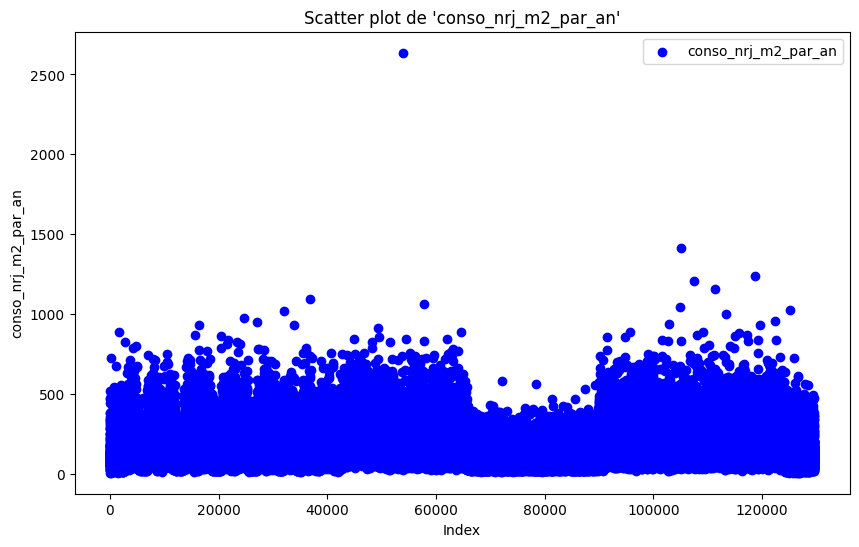

In [18]:
"""
On va détecter les outliers avec la méthode des quantiles.
"""

colonne = "conso_nrj_m2_par_an"

# Visualiser les résultats avec un scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data.index, data[colonne], color='blue', label=colonne)
plt.title(f"Scatter plot de '{colonne}'")
plt.xlabel("Index")
plt.ylabel(colonne)
plt.legend()
plt.show()

In [19]:
# Définir la colonne dynamique
colonne = "conso_nrj_m2_par_an"

# Calculer les quartiles
Q1 = data[colonne].quantile(0.25)
Q3 = data[colonne].quantile(0.75)
IQR = Q3 - Q1

# Définir les bornes pour les outliers
lower_bound = Q1 - 2 * IQR
upper_bound = Q3 + 2 * IQR

# Identifier les outliers
outliers = data[(data[colonne] < lower_bound) | (data[colonne] > upper_bound)]

# Afficher les valeurs des outliers détectés
print("Valeurs des outliers détectés :")
print(outliers[colonne].values)

# Afficher le nombre d'outliers détectés
print(f"Nombre d'outliers détectés : {outliers.shape[0]}")


Valeurs des outliers détectés :
[471.1 518.4 466.8 ... 459.9 490.5 475.7]
Nombre d'outliers détectés : 2325


In [20]:
"""
On enlève les outliers détectés sur notre target variable.
(outliers possibles sur les autres features)
"""

# Supprimer les lignes contenant des outliers
data = data[(data[colonne] >= lower_bound) & (data[colonne] <= upper_bound)]
print(f"Nombre de lignes après suppression des outliers : {data.shape[0]}")

Nombre de lignes après suppression des outliers : 127270


### CORRELATION

In [21]:
# CLASSEMENT DES CORRELATIONS DES VARIABLES AVEC Y

# Définir la colonne target y
y = "conso_nrj_m2_par_an"

# Filtrer les colonnes pertinentes dans le DataFrame
data_for_corr = data[data.columns]

# Calculer la matrice de corrélation
correlation_matrix = data_for_corr.corr()

# Extraire les corrélations avec la variable cible 'y'
correlations_with_y = correlation_matrix[y].drop(y)  # Exclure la corrélation de 'y' avec elle-même

# Définir des seuils pour les différentes forces de corrélation
thresholds = {
    'Modérée': 0.4,
    'Forte': 0.6,
    'Très forte': 0.8
}

# Créer des listes pour chaque catégorie de corrélation
moderate_correlations = correlations_with_y[(correlations_with_y.abs() > thresholds['Modérée']) & (correlations_with_y.abs() <= thresholds['Forte'])]
strong_correlations = correlations_with_y[(correlations_with_y.abs() > thresholds['Forte']) & (correlations_with_y.abs() <= thresholds['Très forte'])]
very_strong_correlations = correlations_with_y[correlations_with_y.abs() > thresholds['Très forte']]

# Afficher les résultats
print("Colonnes avec une corrélation modérée avec la variable cible y:")
print(moderate_correlations)

print("\nColonnes avec une corrélation forte avec la variable cible y:")
print(strong_correlations)

print("\nColonnes avec une corrélation très forte avec la variable cible y:")
print(very_strong_correlations)


Colonnes avec une corrélation modérée avec la variable cible y:
Période_construction                    0.492715
Conso_5_usages_é_primaire               0.530948
Conso_chauffage_é_primaire              0.568942
Conso_chauffage_dépensier_é_primaire    0.558946
Coût_total_5_usages_énergie_n°1         0.511000
Coût_chauffage_énergie_n°1              0.572724
Emission_GES_5_usages_énergie_n°1       0.597901
Coût_total_5_usages                     0.572002
Coût_chauffage                          0.590051
Coût_chauffage_dépensier                0.580870
Deperditions_enveloppe                  0.434817
Déperditions_murs                       0.521557
Qualité_isolation_murs                  0.585688
Qualité_isolation_plancher_bas          0.423037
Besoin_chauffage                        0.571153
Name: conso_nrj_m2_par_an, dtype: float64

Colonnes avec une corrélation forte avec la variable cible y:
Conso_5_usages_é_finale                                      0.688657
Conso_chauffage_é_finale  

In [22]:
# CORRELATION AVEC Y

correlations_df = correlations_with_y.reset_index()
correlations_df.columns = ["variables", "correlation"]
correlations_df = correlations_df.sort_values(by="correlation", ascending=False)

correlations_df

,variables,correlation
5,Etiquette_GES,0.827910
40,Emission_GES_5_usages_par_m²,0.823775
6,Etiquette_DPE,0.807683
30,Conso_5_usages_par_m²_é_primaire,0.760790
92,Conso_chauffage_installation_chauffage_n°1,0.711165
...,...,...
54,Coût_ECS_énergie_n°1,-0.196331
91,Besoin_refroidissement_dépensier,-0.206121
103,Volume_stockage_générateur_ECS_n°1,-0.227515
70,Isolation_toiture_(0/1),-0.372577


# REGRESSION LINEAIRE 1

## REGRESSION

### IMPLEMENTATION DU MODELE

In [23]:
# MODELE DE REGRESSION LINEAIRE

X = data.drop(columns=["conso_nrj_m2_par_an"])
y = data["conso_nrj_m2_par_an"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


# EVALUATION
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


# COEFS
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])

Mean Squared Error: 132.7413885540124
R-squared: 0.9823636634712201


### VERIFICATION DES HYPS DU MODELE

https://www.alliage-ad.com/tutoriels-r/comment-verifier-les-hypotheses-de-la-regression-lineaire/

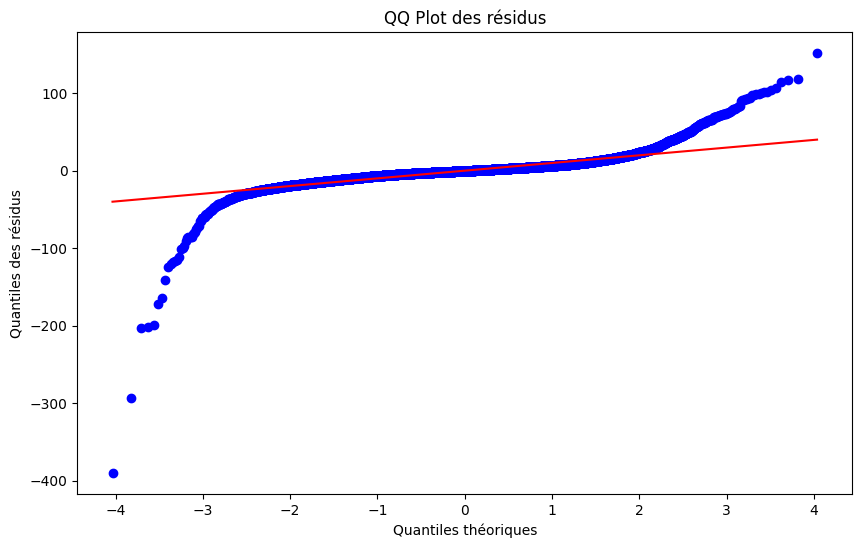

In [24]:
# HYPOTHESE DE NORMALITE DES RESIDUS

# Calculer les résidus
residuals = y_test - y_pred

# Tracer le QQ plot des résidus
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot des résidus")
plt.xlabel("Quantiles théoriques")
plt.ylabel("Quantiles des résidus")
plt.show()

--> résidus ne suivent pas exactement une loi normale : présence de kurtosis élevée

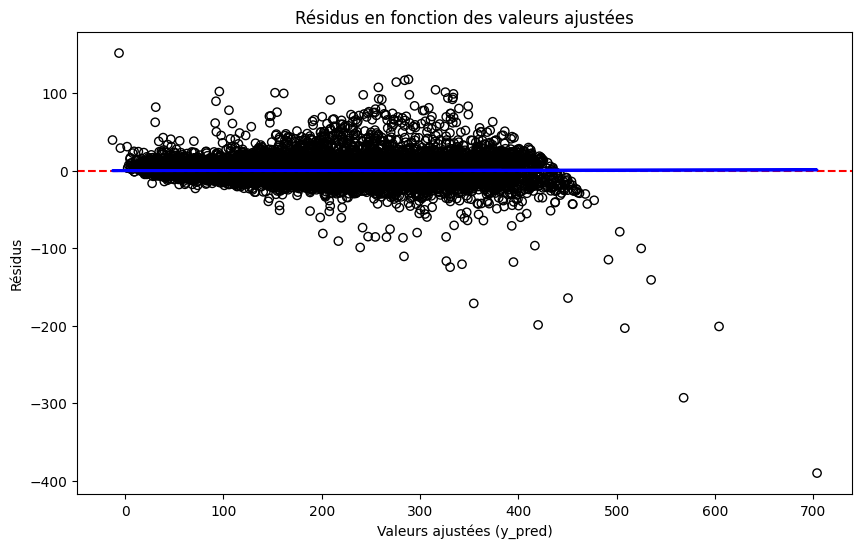

In [25]:
# HYPOTHESE DE LINEARITE DU MODELE

# Tracer les résidus en fonction des valeurs ajustées
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, edgecolor='k', facecolor='none')
plt.axhline(y=0, color='r', linestyle='--')

# Ajuster une ligne de tendance aux résidus
z = np.polyfit(y_pred, residuals, 1)
p = np.poly1d(z)
plt.plot(y_pred, p(y_pred), color='blue', linestyle='-', linewidth=2)

plt.title("Résidus en fonction des valeurs ajustées")
plt.xlabel("Valeurs ajustées (y_pred)")
plt.ylabel("Résidus")
plt.show()

--> droite de tendance quasi horizontale --> relation linéaire

## ANALYSE DE COLINEARITE DES VARIABLES

In [26]:
# COLINEARITE DES VARIABLES

X_numeric = X.apply(pd.to_numeric, errors='coerce')

# Remplir les valeurs manquantes avec la moyenne de chaque colonne
X_numeric = X_numeric.fillna(X_numeric.mean())


# Calculer le VIF : Variance Inflation Factor
# VIF = 1 : Aucune corrélation entre cette variable et les autres variables explicatives.
# 1 < VIF < 5 : Corrélation modérée, généralement acceptable.
# VIF ≥ 5 : Corrélation élevée, potentiellement problématique.
# VIF ≥ 10 : Corrélation très élevée, indiquant une multicolinéarité sévère

vif_data = pd.DataFrame()
vif_data["feature"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]

print(vif_data)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                                              feature           VIF
0                                  Date_réception_DPE  7.414718e+01
1                              Date_établissement_DPE  3.002400e+15
2                          Date_visite_diagnostiqueur  1.039154e+00
3                               Date_fin_validité_DPE  2.434378e+14
4                                         Version_DPE  2.377221e-12
..                                                ...           ...
100  Surface_habitable_desservie_par_installation_ECS  2.178193e+01
101                 Conso_é_finale_générateur_ECS_n°1           inf
102       Conso_é_finale_dépensier_générateur_ECS_n°1  4.545486e+10
103                Volume_stockage_générateur_ECS_n°1  2.378355e+00
104              Production_électricité_PV_(kWhep/an)  1.084397e+00

[105 rows x 2 columns]


In [27]:
vif_data = vif_data.sort_values(by='VIF', ascending=False)
vif_data.rename(columns={"feature": "Variable"}, inplace=True)
vif_data.head(15)

,Variable,VIF
101,Conso_é_finale_générateur_ECS_n°1,inf
97,Conso_é_finale_installation_ECS,inf
1,Date_établissement_DPE,3.002400e+15
3,Date_fin_validité_DPE,2.434378e+14
102,Conso_é_finale_dépensier_générateur_ECS_n°1,4.545486e+10
98,Conso_é_finale_dépensier_installation_ECS,4.545463e+10
20,Conso_5_usages_é_finale,3.080352e+07
21,Conso_chauffage_é_finale,2.810379e+07
33,Conso_éclairage_é_primaire,8.085382e+06
23,Conso_éclairage_é_finale,8.085262e+06


In [49]:
vif_data['VIF'].describe()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    1.050000e+02
mean              inf
std               NaN
min      2.377221e-12
25%      4.891549e+00
50%      7.776607e+01
75%      9.699798e+03
max               inf
Name: VIF, dtype: float64

--> au vu de la mediane (=77), il y a beaucoup de colinearite parmi notre jeu de donnes de variables explicatives

## ANALYSE DES COEFS

### DISTRIBUTION DES COEFS

In [28]:
coefficients['Coefficient'].describe()

count    105.000000
mean       0.093712
std        4.132452
min      -15.934838
25%       -0.058548
50%       -0.000473
75%        0.010312
max       32.579202
Name: Coefficient, dtype: float64

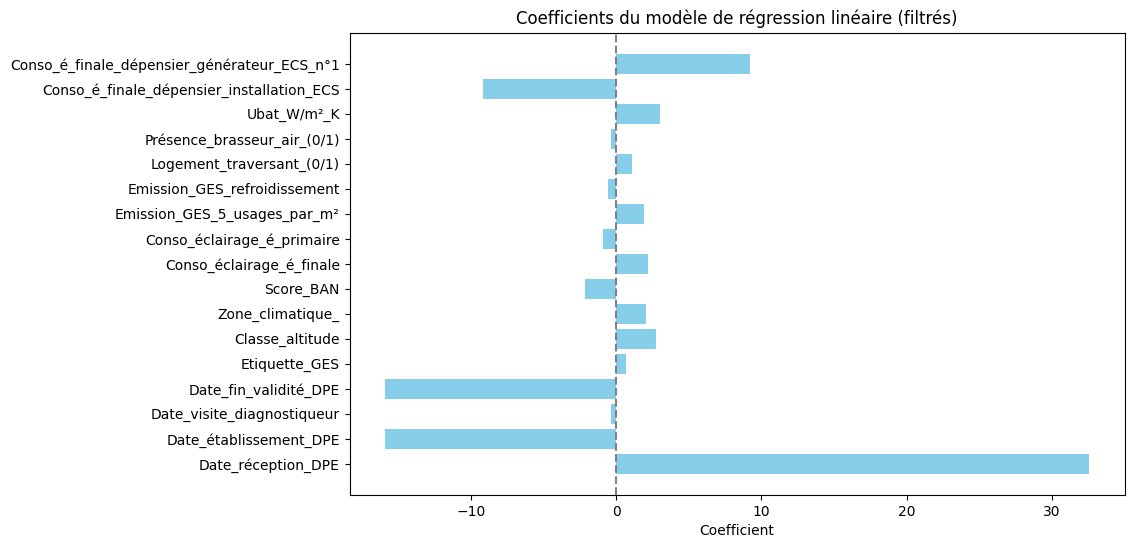

In [29]:
mean_coef = coefficients['Coefficient'].mean()
std_coef = coefficients['Coefficient'].std()

# Filtrer les coefficients qui sont supérieurs ou inférieurs à la moyenne de plus de 0.1 écart type
filtered_coefficients = coefficients[(coefficients['Coefficient'] > mean_coef + 0.1 * std_coef) | 
                                     (coefficients['Coefficient'] < mean_coef - 0.1 * std_coef)]

# Tracer les coefficients filtrés
plt.figure(figsize=(10, 6))
plt.barh(filtered_coefficients.index, filtered_coefficients['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.title('Coefficients du modèle de régression linéaire (filtrés)')
plt.axvline(x=0, color='grey', linestyle='--')
plt.show()

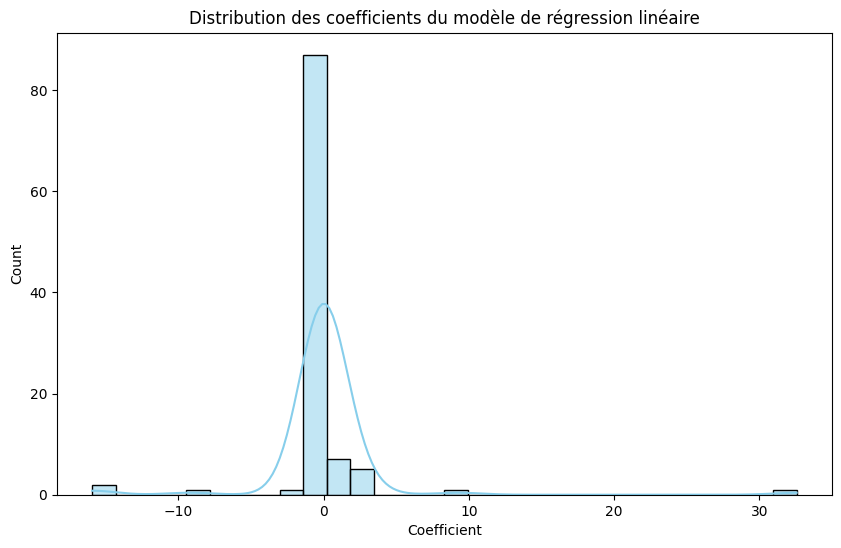

In [30]:
# Tracer la distribution des coefficients
plt.figure(figsize=(10, 6))
sns.histplot(coefficients['Coefficient'], kde=True, bins=30, color='skyblue')
plt.xlabel('Coefficient')
plt.title('Distribution des coefficients du modèle de régression linéaire')
plt.show()

### TOP COEFS

In [31]:
top_N = 10

top_abs = coefficients.reindex(coefficients['Coefficient'].abs().sort_values(ascending=False).index).head(top_N)
print("Top coefficients par valeur absolue :")
top_abs

Top coefficients par valeur absolue :


,Coefficient
Date_réception_DPE,32.579202
Date_établissement_DPE,-15.934838
Date_fin_validité_DPE,-15.934838
Conso_é_finale_dépensier_générateur_ECS_n°1,9.222946
Conso_é_finale_dépensier_installation_ECS,-9.196051
Ubat_W/m²_K,2.987659
Classe_altitude,2.751091
Conso_éclairage_é_finale,2.204604
Score_BAN,-2.168090
Zone_climatique_,2.059052


In [32]:
top_pos = coefficients[coefficients['Coefficient'] > 0].sort_values(by='Coefficient', ascending=False).head(top_N)
print("\nTop coefficients par valeur positive :")
top_pos


Top coefficients par valeur positive :


,Coefficient
Date_réception_DPE,32.579202
Conso_é_finale_dépensier_générateur_ECS_n°1,9.222946
Ubat_W/m²_K,2.987659
Classe_altitude,2.751091
Conso_éclairage_é_finale,2.204604
Zone_climatique_,2.059052
Emission_GES_5_usages_par_m²,1.883234
Logement_traversant_(0/1),1.080256
Etiquette_GES,0.678711
Inertie_lourde_(0/1),0.481066


In [33]:
top_neg = coefficients[coefficients['Coefficient'] < 0].sort_values(by='Coefficient', ascending=True).head(top_N)
print("\nTop coefficients par valeur négative :")
top_neg


Top coefficients par valeur négative :


,Coefficient
Date_établissement_DPE,-15.934838
Date_fin_validité_DPE,-15.934838
Conso_é_finale_dépensier_installation_ECS,-9.196051
Score_BAN,-2.168090
Conso_éclairage_é_primaire,-0.883333
Emission_GES_refroidissement,-0.540214
Présence_brasseur_air_(0/1),-0.385573
Date_visite_diagnostiqueur,-0.383936
Coût_éclairage,-0.285841
Nombre_niveau_logement,-0.221575


## ANALYSE DE CORRELATION

In [34]:
# TRANSPOSITION DE LA MATRICE DE CORREL EN TABLEAU

correlation_matrix = X.corr()

# stocker les couples de variables et leurs coefficients de corrélation
correlation_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        var1 = correlation_matrix.columns[i]
        var2 = correlation_matrix.columns[j]
        correlation = correlation_matrix.iloc[i, j]
        correlation_pairs.append((var1, var2, correlation))

correlation_df = pd.DataFrame(correlation_pairs, columns=['Variable 1', 'Variable 2', 'Correlation'])

correlation_df

,Variable 1,Variable 2,Correlation
0,Date_réception_DPE,Date_établissement_DPE,0.991715
1,Date_réception_DPE,Date_visite_diagnostiqueur,0.139095
2,Date_réception_DPE,Date_fin_validité_DPE,0.991715
3,Date_réception_DPE,Version_DPE,NaN
4,Date_réception_DPE,Etiquette_GES,-0.008288
...,...,...,...
5455,Conso_é_finale_générateur_ECS_n°1,Volume_stockage_générateur_ECS_n°1,0.091398
5456,Conso_é_finale_générateur_ECS_n°1,Production_électricité_PV_(kWhep/an),-0.047127
5457,Conso_é_finale_dépensier_générateur_ECS_n°1,Volume_stockage_générateur_ECS_n°1,0.051665
5458,Conso_é_finale_dépensier_générateur_ECS_n°1,Production_électricité_PV_(kWhep/an),-0.049743


In [35]:
correlation_df['Correlation'].describe()

count    5356.000000
mean        0.198258
std         0.283478
min        -0.815890
25%        -0.003070
50%         0.099589
75%         0.368913
max         1.000000
Name: Correlation, dtype: float64

In [36]:
# AFFICHE LES COUPLES DE VARIABLE AYANT UNE CORREL >= SEUIL

seuil = 0.75
top_N = 10

high_correl = correlation_df[correlation_df['Correlation']>=seuil]
print(f"Nombre de coefficients de correl >= {seuil} : {high_correl.shape[0]}/{correlation_df.shape[0]} (= {high_correl.shape[0]/correlation_df.shape[0]*100:.2f}%)")
top_correl = high_correl.sort_values(by='Correlation', ascending=False).head(top_N)

top_correl

Nombre de coefficients >= 0.75 : 385/5460 (= 7.05%)


,Variable 1,Variable 2,Correlation
5435,Conso_é_finale_installation_ECS,Conso_é_finale_générateur_ECS_n°1,1.000000
105,Date_établissement_DPE,Date_fin_validité_DPE,1.000000
5442,Conso_é_finale_dépensier_installation_ECS,Conso_é_finale_dépensier_générateur_ECS_n°1,1.000000
2148,Conso_éclairage_é_finale,Conso_éclairage_é_primaire,1.000000
2388,Conso_refroidissement_é_finale,Conso_refroidissement_é_primaire,0.999993
2543,Conso_auxiliaires_é_finale,Conso_auxiliaires_é_primaire,0.999983
5415,Conso_chauffage_générateur_n°1_installation_n°1,Conso_chauffage_dépensier_générateur_n°1_insta...,0.999226
5382,Conso_chauffage_installation_chauffage_n°1,Conso_chauffage_dépensier_installation_chauffa...,0.999094
1974,Conso_chauffage_é_finale,Conso_chauffage_dépensier_é_finale,0.999089
1007,Surface_habitable_logement,Conso_éclairage_é_finale,0.998563


In [37]:
# DETERMINER VARIABLES COUPABLES DE CORREL ELEVEES

seuil = 0.75

# Filtrer les variables corrélées au-dessus du seuil
high_correl = correlation_df[correlation_df['Correlation'] >= seuil]

# Compter pour chaque variable le nombre de fois que le coef de correl depasse le seuil
high_correl_counts = pd.concat([
    high_correl['Variable 1'], 
    high_correl['Variable 2']
]).value_counts()

max_possible_count = len(high_correl_counts) - 1
print(f"Nombre maximal de count possible selon le seuil : {max_possible_count}")

# Afficher les variables les plus corrélées
high_correl_counts.head(10)

Nombre maximal de count possible selon le seuil : 76


Coût_chauffage                                               25
Coût_total_5_usages                                          25
Conso_5_usages_é_finale                                      25
Conso_chauffage_é_finale                                     25
Conso_chauffage_dépensier_é_finale                           25
Conso_chauffage_installation_chauffage_n°1                   24
Conso_chauffage_dépensier_générateur_n°1_installation_n°1    24
Conso_chauffage_générateur_n°1_installation_n°1              24
Coût_chauffage_dépensier                                     24
Conso_chauffage_é_finale_énergie_n°1                         24
Name: count, dtype: int64

In [38]:
# CREATION D'UN GRAND TABLEAU D'ANALYSE DES VARIABLES
# 'Variable', 'Coefficient', 'correl_y', 'VIF', 'Mean Correlation', 'Top 1 Correlation', 'Top 2 Correlation', 'Top 3 Correlation'


# Calculer la matrice de corrélation des variables explicatives
correlation_matrix = X.corr()

# Dictionnaires permettant de stocker les valeurs pour calculer 'Mean Correlation'
correlation_sums = {col: 0 for col in correlation_matrix.columns}
correlation_counts = {col: 0 for col in correlation_matrix.columns}

# Parcourir la matrice de corrélation pour extraire les couples de variables et leurs coefficients de corrélation
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        var1 = correlation_matrix.columns[i]
        var2 = correlation_matrix.columns[j]
        correlation = correlation_matrix.iloc[i, j]
        
        # Vérifier si la corrélation n'est pas NaN
        if not pd.isna(correlation):
            # Ajouter la corrélation aux sommes et incrémenter les compteurs
            correlation_sums[var1] += abs(correlation)
            correlation_sums[var2] += abs(correlation)
            correlation_counts[var1] += 1
            correlation_counts[var2] += 1

# Calculer la corrélation moyenne pour chaque variable
correlation_means = {var: correlation_sums[var] / correlation_counts[var] for var in correlation_sums if correlation_counts[var] > 0}
correlation_means_df = pd.DataFrame(list(correlation_means.items()), columns=['Variable', 'Mean Correlation'])

# Ajouter les top3 des variables corrélées à la variable var
top_correlations = {var: [] for var in correlation_matrix.columns}
for var in correlation_matrix.columns:
    sorted_correlations = correlation_matrix[var].abs().sort_values(ascending=False)
    top_3 = sorted_correlations.index[1:4]      # Exclure la corrélation avec elle-même : la premiere est la plus elevee, elle vaut 1, c est la correl de la variable avec elle meme
    top_correlations[var] = [f"{v} ({correlation_matrix.loc[var, v]:.2f})" for v in top_3]

correlation_means_df['Top 1 Correlation'] = correlation_means_df['Variable'].map(lambda x: top_correlations[x][0])
correlation_means_df['Top 2 Correlation'] = correlation_means_df['Variable'].map(lambda x: top_correlations[x][1])
correlation_means_df['Top 3 Correlation'] = correlation_means_df['Variable'].map(lambda x: top_correlations[x][2])


# Coefs de la regression lineaire
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
correlation_means_df = correlation_means_df.merge(coefficients, left_on='Variable', right_index=True)

# Correl avec y
correlations_df = correlations_with_y.reset_index()
correlations_df.columns = ["Variable", "correl_y"]
correlation_means_df = correlation_means_df.merge(correlations_df, on='Variable')

# Coef VIF
correlation_means_df = correlation_means_df.merge(vif_data, on='Variable')


# Traitement du tableau final
cols = ['Variable', 'Coefficient', 'correl_y', 'VIF', 'Mean Correlation', 'Top 1 Correlation', 'Top 2 Correlation', 'Top 3 Correlation']
correlation_means_df = correlation_means_df[cols]
correlation_means_df = correlation_means_df.sort_values(by='correl_y', ascending=False)

# Exportation
correlation_means_df.to_excel('correlation_coef_vif_reg1.xlsx', index=False)


correlation_means_df.head(15)

,Variable,Coefficient,correl_y,VIF,Mean Correlation,Top 1 Correlation,Top 2 Correlation,Top 3 Correlation
4,Etiquette_GES,0.678711,0.827910,2.142389e+01,0.284680,Emission_GES_5_usages_par_m² (0.95),Emission_GES_5_usages (0.76),Emission_GES_5_usages_énergie_n°1 (0.73)
39,Emission_GES_5_usages_par_m²,1.883234,0.823775,1.884292e+01,0.282430,Etiquette_GES (0.95),Emission_GES_5_usages (0.81),Emission_GES_5_usages_énergie_n°1 (0.77)
5,Etiquette_DPE,0.262316,0.807683,1.416796e+01,0.266534,Conso_5_usages_par_m²_é_primaire (0.92),Ubat_W/m²_K (0.62),Etiquette_GES (0.60)
29,Conso_5_usages_par_m²_é_primaire,0.426762,0.760790,1.325832e+01,0.236223,Etiquette_DPE (0.92),Ubat_W/m²_K (0.61),Conso_chauffage_é_primaire (0.60)
91,Conso_chauffage_installation_chauffage_n°1,-0.000473,0.711165,1.332440e+04,0.412392,Conso_chauffage_dépensier_installation_chauffa...,Conso_chauffage_é_finale (0.98),Conso_chauffage_dépensier_é_finale (0.98)
94,Conso_chauffage_générateur_n°1_installation_n°1,0.004955,0.706705,1.331749e+04,0.405681,Conso_chauffage_dépensier_générateur_n°1_insta...,Conso_chauffage_é_finale_énergie_n°1 (0.99),Conso_5_usages_é_finale_énergie_n°1 (0.98)
92,Conso_chauffage_dépensier_installation_chauffa...,0.000349,0.706642,1.317124e+04,0.412597,Conso_chauffage_installation_chauffage_n°1 (1.00),Conso_chauffage_dépensier_é_finale (0.98),Conso_chauffage_é_finale (0.98)
95,Conso_chauffage_dépensier_générateur_n°1_insta...,-0.003603,0.702036,1.306161e+04,0.405685,Conso_chauffage_générateur_n°1_installation_n°...,Conso_chauffage_é_finale_énergie_n°1 (0.98),Conso_5_usages_é_finale_énergie_n°1 (0.98)
20,Conso_chauffage_é_finale,-0.007506,0.700350,2.810379e+07,0.416887,Conso_chauffage_dépensier_é_finale (1.00),Conso_5_usages_é_finale (1.00),Conso_chauffage_installation_chauffage_n°1 (0.98)
49,Conso_chauffage_é_finale_énergie_n°1,-0.014782,0.698375,9.699798e+03,0.410180,Conso_5_usages_é_finale_énergie_n°1 (1.00),Conso_chauffage_générateur_n°1_installation_n°...,Conso_chauffage_dépensier_générateur_n°1_insta...


In [39]:
correlation_means_df["Mean Correlation"].describe()

count    104.000000
mean       0.230440
std        0.128469
min        0.003866
25%        0.114395
50%        0.239305
75%        0.346140
max        0.421662
Name: Mean Correlation, dtype: float64

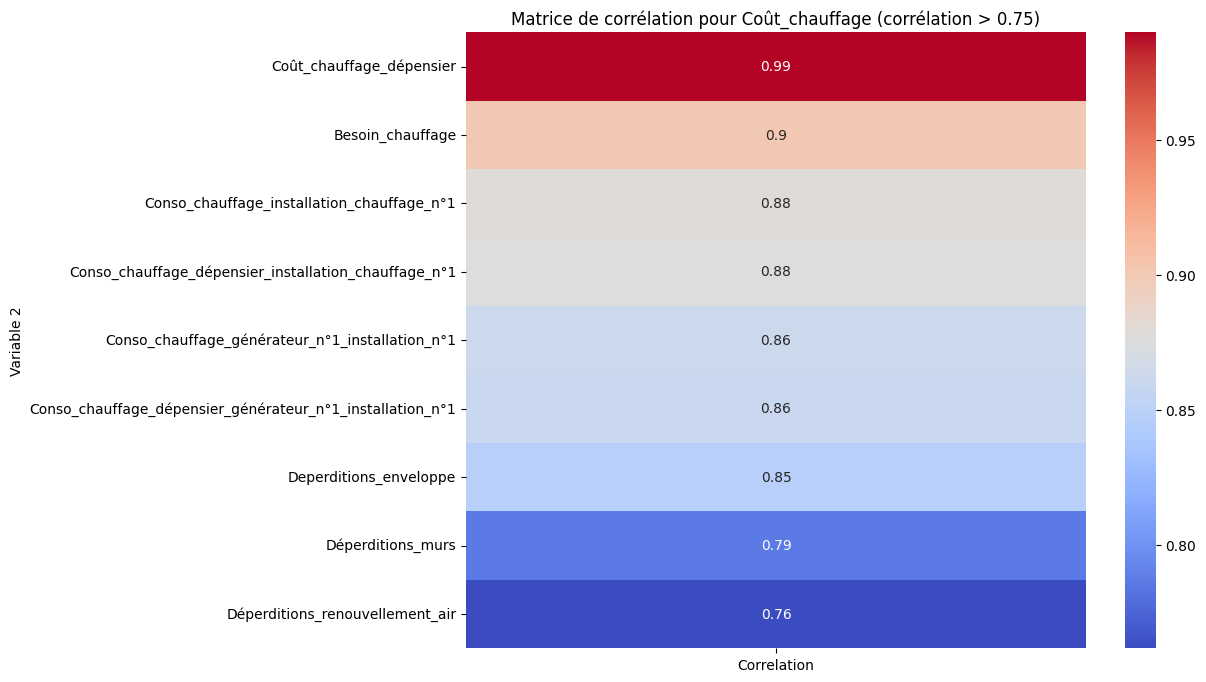

In [41]:
# SCRIPT POUR EXTRAIRE LES CORRELATIONS POUR UNE VARIABLE AVEC LES AUTRES SELON UN SEUIL DE CORREL

# A choisir
variable_name = 'Coût_chauffage'    # variable à analyser
seuil = 0.75                        # seuil de correl    

correlation_with_variable = correlation_df.loc[correlation_df['Variable 1'] == variable_name, ['Variable 2', 'Correlation']]


# Filtrer les corrélations supérieures au seuil
correlation_with_variable = correlation_with_variable[correlation_with_variable['Correlation'] > seuil]
correlation_with_variable = correlation_with_variable.sort_values(by='Correlation', ascending=False)
correlation_with_variable = correlation_with_variable.set_index('Variable 2')

# Afficher la matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_with_variable, annot=True, cmap='coolwarm', cbar=True)
plt.title(f"Matrice de corrélation pour {variable_name} (corrélation > {seuil})")
plt.show()

## REGRESSION AVEC REGULARISATION

In [42]:
# REGULARISATION LASSO : pour éliminer des variables

# Utiliser LassoCV pour trouver les hyperparamètres optimaux
lasso = LassoCV(cv=5, random_state=42).fit(X_train, y_train)
y_pred = lasso.predict(X_test)

# Eval
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(f"Meilleur alpha trouvé par LassoCV: {lasso.alpha_}")

# Coefs
lasso_coefficients = pd.DataFrame({'Variable': X.columns, 'Coefficient': lasso.coef_})

Mean Squared Error: 2307.314226431594
R-squared: 0.6934447453182137
Meilleur alpha trouvé par LassoCV: 4407.552884972095


--> score ok mais sans plus

In [43]:
# COEFS ABS LES PLUS GRANDS
top_N = 10
top_abs = lasso_coefficients.reindex(lasso_coefficients['Coefficient'].abs().sort_values(ascending=False).index).head(top_N)
print("Top coefficients par valeur absolue :")
top_abs

Top coefficients par valeur absolue :


,Variable,Coefficient
33,Conso_éclairage_é_primaire,-0.076553
21,Conso_chauffage_é_finale,0.004211
29,Conso_5_usages_é_primaire,-0.004013
32,Conso_chauffage_dépensier_é_primaire,0.003974
92,Conso_chauffage_installation_chauffage_n°1,0.001281
95,Conso_chauffage_générateur_n°1_installation_n°1,0.001166
90,Besoin_chauffage,-0.000757
91,Besoin_refroidissement_dépensier,-0.000257
17,Coordonnée_cartographique_Y_(BAN),0.000028
87,Apports_internes_saison_froid,-0.000025


--> coefs très petits

In [44]:
# REGULARISATION ELASTICNET : pour supprimer moins de variables que Lasso et réduire les coefs afin de gérer la multicolinearite
# On espere garder un peu plus de variables

# Utiliser ElasticNetCV pour trouver les hyperparamètres optimaux
elastic_net = ElasticNetCV(cv=5, random_state=42).fit(X_train, y_train)
y_pred = elastic_net.predict(X_test)

# Évaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(f"Meilleur alpha trouvé par ElasticNetCV: {elastic_net.alpha_}")
print(f"Meilleur l1_ratio trouvé par ElasticNetCV: {elastic_net.l1_ratio_}")

# Coefs
elastic_net_coefficients = pd.DataFrame({'Variable': X.columns, 'Coefficient': elastic_net.coef_})

Mean Squared Error: 2422.957917120603
R-squared: 0.6780800495843611
Meilleur alpha trouvé par ElasticNetCV: 8815.10576994419
Meilleur l1_ratio trouvé par ElasticNetCV: 0.5


--> score legerement inferieur à Lasso

In [45]:
# COEFS ABS LES PLUS GRANDS
top_N = 10
top_abs = elastic_net_coefficients.reindex(elastic_net_coefficients['Coefficient'].abs().sort_values(ascending=False).index).head(top_N)
print("Top coefficients par valeur absolue :")
top_abs

Top coefficients par valeur absolue :


,Variable,Coefficient
33,Conso_éclairage_é_primaire,-0.062238
29,Conso_5_usages_é_primaire,-0.004506
32,Conso_chauffage_dépensier_é_primaire,0.004476
21,Conso_chauffage_é_finale,0.004104
92,Conso_chauffage_installation_chauffage_n°1,0.001303
95,Conso_chauffage_générateur_n°1_installation_n°1,0.001228
90,Besoin_chauffage,-0.000917
91,Besoin_refroidissement_dépensier,-0.000619
17,Coordonnée_cartographique_Y_(BAN),0.000029
87,Apports_internes_saison_froid,-0.000026


--> pas de grande difference avec les coefs du modele Lasso, et meme nombre de variables séléctionnées

## SUPPRESSION DES VARIABLES

### SUPRRESION DES VARIABLES NON PERTINENTES

Selection manuelle des variables. On cherche à supprimer les variables qui n'apportent pas d'information quant à la réalisation de travaux permmettant d'améliorer l'efficacité énergétique des logements

In [117]:
columns_to_drop = [
    "Date_établissement_DPE",
    "Date_fin_validité_DPE",
    "Date_réception_DPE",
    "Date_visite_diagnostiqueur",
    "Hauteur_sous-plafond",
    "Classe_altitude",
    "Code_postal_(BAN)",
    "Code_postal_(brut)",
    "N°_région_(BAN)",
    "Nombre_niveau_logement",
    "Logement_traversant_(0/1)",
    "Présence_brasseur_air_(0/1)",
    "Coordonnée_cartographique_X_(BAN)",
    "Indicateur_confort_été",
    "Coordonnée_cartographique_Y_(BAN)",
    "Zone_climatique_",
    "Période_construction",
    "Etiquette_DPE",
    "Etiquette_GES",
    "Surface_habitable_logement"
]

data_cleaned = data.drop(columns=columns_to_drop)
data_cleaned.head(10)

,Version_DPE,Classe_inertie_bâtiment,Score_BAN,Conso_5_usages_é_finale,conso_nrj_m2_par_an,Conso_chauffage_é_finale,Conso_chauffage_dépensier_é_finale,Conso_éclairage_é_finale,Conso_ECS_é_finale,Conso_ECS_dépensier_é_finale,...,Conso_chauffage_générateur_n°1_installation_n°1,Conso_chauffage_dépensier_générateur_n°1_installation_n°1,Conso_é_finale_installation_ECS,Conso_é_finale_dépensier_installation_ECS,Nombre_logements_desservis_par_installation_ECS,Surface_habitable_desservie_par_installation_ECS,Conso_é_finale_générateur_ECS_n°1,Conso_é_finale_dépensier_générateur_ECS_n°1,Volume_stockage_générateur_ECS_n°1,Production_électricité_PV_(kWhep/an)
0,2.4,2.0,0.56,17995.3,216.0,14692.7,18182.9,150.3,2808.0,3437.9,...,14692.7,18182.9,2808.0,3437.9,1.0,83.2,2808.0,3437.9,100.0,10416.9
1,2.4,3.0,0.65,10717.9,73.0,7721.5,9927.1,265.8,2516.3,3166.0,...,7815.5,10046.5,2594.4,3262.9,1.0,145.0,2594.4,3262.9,300.0,4683.3
2,2.4,3.0,0.77,18056.4,137.8,15859.4,19937.9,249.5,2105.4,2751.8,...,5172.9,6503.2,2105.4,2751.8,1.0,131.0,2105.4,2751.8,150.0,4658.2
3,2.4,2.0,0.84,16127.7,56.0,14353.3,17840.9,543.3,645.9,911.5,...,7618.1,9467.7,668.5,943.1,1.0,285.0,668.5,943.1,200.0,11223.0
4,2.4,1.0,0.50,14681.3,136.0,12552.3,15762.5,204.6,1924.5,2436.3,...,12752.8,16011.4,2003.3,2534.9,1.0,107.9,2003.3,2534.9,200.0,7628.7
5,2.4,2.0,0.51,4666.3,52.0,2620.4,3453.0,174.6,1603.2,2160.2,...,2620.4,3453.0,1603.2,2160.2,1.0,89.6,1603.2,2160.2,0.0,735.8
6,2.4,2.0,0.50,4399.4,52.0,2345.4,3036.3,157.2,1604.5,2168.7,...,2345.4,3036.3,1604.5,2168.7,1.0,84.2,1604.5,2168.7,0.0,666.4
7,2.4,2.0,0.50,3796.3,58.0,1942.0,2508.7,119.8,1447.5,1947.1,...,1942.0,2508.7,1447.5,1947.1,1.0,64.4,1447.5,1947.1,0.0,643.2
8,2.4,2.0,0.67,5014.8,47.0,2303.8,2997.6,191.1,1905.9,2410.4,...,2340.5,3044.7,1983.7,2507.3,1.0,104.8,1983.7,2507.3,200.0,7833.7
9,2.4,3.0,0.49,40726.6,220.0,38966.3,47259.6,324.3,649.6,916.9,...,29795.6,36131.5,672.8,949.1,1.0,184.5,672.8,949.1,270.0,7739.8


--> On estime qu'en tant que prestataire de travaux, nous ne pouvons pas agir sur ces variables pour améliorer l'efficacité énergétique du logement. Ou bien que ces variables n'apportent pas d'information sur l'efficacité énergétique.

### SUPPRESSION DES VARIABLES TRES COLINEAIRES

Selection manuelle des variables. On elimine des variables qui sont très colineaires avec d'autres (sur la base du VIF et du Mean Correlation) et qui sont redondantes à d'autres (correl proche de 1 avec d'autres variables).

In [118]:
variables_colinear = [
    "Conso_chauffage_é_finale",
    "Conso_chauffage_dépensier_é_finale",
    "Conso_chauffage_installation_chauffage_n°1",
    "Coût_chauffage",
    "Coût_chauffage_dépensier",
    "Conso_chauffage_é_finale_énergie_n°1",
    "Conso_chauffage_générateur_n°1_installation_n°1",
    "Conso_chauffage_dépensier_générateur_n°1_installation_n°1",
    "Conso_chauffage_dépensier_installation_chauffage_n°1",
    "Conso_5_usages_é_primaire",
    "Conso_chauffage_dépensier_é_primaire",
    "Emission_GES_5_usages_énergie_n°1",
    "Emission_GES_chauffage_dépensier",
    "Emission_GES_chauffage_énergie_n°1",
    "Conso_éclairage_é_primaire",
    "Conso_refroidissement_é_primaire",
    "Conso_refroidissement_dépensier_é_finale",
    "Coût_refroidissement"
]

retrieved_rows = correlation_means_df.loc[correlation_means_df['Variable'].isin(variables_colinear)]
retrieved_rows

,Variable,Coefficient,correl_y,VIF,Mean Correlation,Top 1 Correlation,Top 2 Correlation,Top 3 Correlation


--> Les variables sélectionnées présentent une forte colinéarité avec les autres variables et ont des coefs de corrélation proches de 1 avec d'autres variables.  
--> On décide de supprimer ces variables

In [119]:
columns_to_drop = [
    "Conso_chauffage_é_finale",
    "Conso_chauffage_dépensier_é_finale",
    "Conso_chauffage_installation_chauffage_n°1",
    "Coût_chauffage",
    "Coût_chauffage_dépensier",
    "Conso_chauffage_é_finale_énergie_n°1",
    "Conso_chauffage_générateur_n°1_installation_n°1",
    "Conso_chauffage_dépensier_générateur_n°1_installation_n°1",
    "Conso_chauffage_dépensier_installation_chauffage_n°1",
    "Conso_5_usages_é_primaire",
    "Conso_chauffage_dépensier_é_primaire",
    "Emission_GES_5_usages_énergie_n°1",
    "Emission_GES_chauffage_dépensier",
    "Emission_GES_chauffage_énergie_n°1",
    "Conso_éclairage_é_primaire",
    "Conso_refroidissement_é_primaire",
    "Conso_refroidissement_dépensier_é_finale",
    "Coût_refroidissement"
]

data_cleaned = data_cleaned.drop(columns=columns_to_drop)
data_cleaned.head()

,Version_DPE,Classe_inertie_bâtiment,Score_BAN,Conso_5_usages_é_finale,conso_nrj_m2_par_an,Conso_éclairage_é_finale,Conso_ECS_é_finale,Conso_ECS_dépensier_é_finale,Conso_refroidissement_é_finale,Conso_auxiliaires_é_finale,...,Besoin_refroidissement_dépensier,Surface_chauffée_installation_chauffage_n°1,Conso_é_finale_installation_ECS,Conso_é_finale_dépensier_installation_ECS,Nombre_logements_desservis_par_installation_ECS,Surface_habitable_desservie_par_installation_ECS,Conso_é_finale_générateur_ECS_n°1,Conso_é_finale_dépensier_générateur_ECS_n°1,Volume_stockage_générateur_ECS_n°1,Production_électricité_PV_(kWhep/an)
0,2.4,2.0,0.56,17995.3,216.0,150.3,2808.0,3437.9,0.0,344.4,...,0.0,83.2,2808.0,3437.9,1.0,83.2,2808.0,3437.9,100.0,10416.9
1,2.4,3.0,0.65,10717.9,73.0,265.8,2516.3,3166.0,0.0,214.3,...,0.0,145.0,2594.4,3262.9,1.0,145.0,2594.4,3262.9,300.0,4683.3
2,2.4,3.0,0.77,18056.4,137.8,249.5,2105.4,2751.8,63.3,0.0,...,3180.6,65.5,2105.4,2751.8,1.0,131.0,2105.4,2751.8,150.0,4658.2
3,2.4,2.0,0.84,16127.7,56.0,543.3,645.9,911.5,145.4,439.8,...,3561.0,67.1,668.5,943.1,1.0,285.0,668.5,943.1,200.0,11223.0
4,2.4,1.0,0.50,14681.3,136.0,204.6,1924.5,2436.3,0.0,0.0,...,0.0,107.9,2003.3,2534.9,1.0,107.9,2003.3,2534.9,200.0,7628.7


# REGRESSIONS LINEAIRES SEQUENTIELLES

## REGRESSION 2

On refait une regression seulement avec les colonnes gardées

In [120]:
# MODELE DE REGRESSION LINEAIRE

X = data_cleaned.drop(columns=["conso_nrj_m2_par_an"])
y = data_cleaned["conso_nrj_m2_par_an"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


# EVALUATION
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


# COEFS
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])

Mean Squared Error: 139.6640180889749
R-squared: 0.9814439064498974


--> meme score que regression 1  
--> supprimer des variables n'a pas enlevé d'information au modèle

In [121]:
top_N = 10

top_abs = coefficients.reindex(coefficients['Coefficient'].abs().sort_values(ascending=False).index).head(top_N)
print("Top coefficients par valeur absolue :")
top_abs

Top coefficients par valeur absolue :


,Coefficient
Conso_é_finale_dépensier_générateur_ECS_n°1,20.514936
Conso_é_finale_dépensier_installation_ECS,-20.483140
Score_BAN,-2.219965
Ubat_W/m²_K,2.085862
Emission_GES_5_usages_par_m²,2.004141
Inertie_lourde_(0/1),1.179380
Qualité_isolation_murs,0.453253
Conso_5_usages_par_m²_é_primaire,0.425866
Classe_inertie_bâtiment,-0.383226
Protection_solaire_exterieure_(0/1),-0.265232


In [122]:
# COLINEARITE DES VARIABLES

X_numeric = X.apply(pd.to_numeric, errors='coerce')

# Remplir les valeurs manquantes avec la moyenne de chaque colonne
X_numeric = X_numeric.fillna(X_numeric.mean())


# Calculer le VIF : Variance Inflation Factor
# VIF = 1 : Aucune corrélation entre cette variable et les autres variables explicatives.
# 1 < VIF < 5 : Corrélation modérée, généralement acceptable.
# VIF ≥ 5 : Corrélation élevée, potentiellement problématique.
# VIF ≥ 10 : Corrélation très élevée, indiquant une multicolinéarité sévère

vif_data = pd.DataFrame()
vif_data["Variable"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]

print(vif_data)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                                            Variable           VIF
0                                        Version_DPE  1.933476e+02
1                            Classe_inertie_bâtiment  2.622256e+00
2                                          Score_BAN  1.983711e+00
3                            Conso_5_usages_é_finale  8.499054e+01
4                           Conso_éclairage_é_finale  8.734201e+01
..                                               ...           ...
62  Surface_habitable_desservie_par_installation_ECS  2.023386e+01
63                 Conso_é_finale_générateur_ECS_n°1           inf
64       Conso_é_finale_dépensier_générateur_ECS_n°1  4.438465e+10
65                Volume_stockage_générateur_ECS_n°1  2.356772e+00
66              Production_électricité_PV_(kWhep/an)  1.026614e+00

[67 rows x 2 columns]


In [123]:
# CREATION D'UN GRAND TABLEAU D'ANALYSE DES VARIABLES
# 'Variable', 'Coefficient', 'correl_y', 'VIF', 'Mean Correlation', 'Top 1 Correlation', 'Top 2 Correlation', 'Top 3 Correlation'


# Calculer la matrice de corrélation des variables explicatives
correlation_matrix = X.corr()

# Dictionnaires permettant de stocker les valeurs pour calculer 'Mean Correlation'
correlation_sums = {col: 0 for col in correlation_matrix.columns}
correlation_counts = {col: 0 for col in correlation_matrix.columns}

# Parcourir la matrice de corrélation pour extraire les couples de variables et leurs coefficients de corrélation
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        var1 = correlation_matrix.columns[i]
        var2 = correlation_matrix.columns[j]
        correlation = correlation_matrix.iloc[i, j]
        
        # Vérifier si la corrélation n'est pas NaN
        if not pd.isna(correlation):
            # Ajouter la corrélation aux sommes et incrémenter les compteurs
            correlation_sums[var1] += abs(correlation)
            correlation_sums[var2] += abs(correlation)
            correlation_counts[var1] += 1
            correlation_counts[var2] += 1

# Calculer la corrélation moyenne pour chaque variable
correlation_means = {var: correlation_sums[var] / correlation_counts[var] for var in correlation_sums if correlation_counts[var] > 0}
correlation_means_df = pd.DataFrame(list(correlation_means.items()), columns=['Variable', 'Mean Correlation'])

# Ajouter les top3 des variables corrélées à la variable var
top_correlations = {var: [] for var in correlation_matrix.columns}
for var in correlation_matrix.columns:
    sorted_correlations = correlation_matrix[var].abs().sort_values(ascending=False)
    top_3 = sorted_correlations.index[1:4]      # Exclure la corrélation avec elle-même : la premiere est la plus elevee, elle vaut 1, c est la correl de la variable avec elle meme
    top_correlations[var] = [f"{v} ({correlation_matrix.loc[var, v]:.2f})" for v in top_3]

correlation_means_df['Top 1 Correlation'] = correlation_means_df['Variable'].map(lambda x: top_correlations[x][0])
correlation_means_df['Top 2 Correlation'] = correlation_means_df['Variable'].map(lambda x: top_correlations[x][1])
correlation_means_df['Top 3 Correlation'] = correlation_means_df['Variable'].map(lambda x: top_correlations[x][2])


# Coefs de la regression lineaire
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
correlation_means_df = correlation_means_df.merge(coefficients, left_on='Variable', right_index=True)

# Correl avec y
correlations_df = correlations_with_y.reset_index()
correlations_df.columns = ["Variable", "correl_y"]
correlation_means_df = correlation_means_df.merge(correlations_df, on='Variable')

# Coef VIF
correlation_means_df = correlation_means_df.merge(vif_data, on='Variable')


# Traitement du tableau final
cols = ['Variable', 'Coefficient', 'correl_y', 'VIF', 'Mean Correlation', 'Top 1 Correlation', 'Top 2 Correlation', 'Top 3 Correlation']
correlation_means_df = correlation_means_df[cols]
correlation_means_df = correlation_means_df.sort_values(by='correl_y', ascending=False)

# Exportation
correlation_means_df.to_excel('correlation_coef_vif_reg2.xlsx', index=False)


correlation_means_df.head(15)

,Variable,Coefficient,correl_y,VIF,Mean Correlation,Top 1 Correlation,Top 2 Correlation,Top 3 Correlation
15,Emission_GES_5_usages_par_m²,2.004141,0.823775,7.515759,0.263210,Emission_GES_5_usages (0.81),Emission_GES_chauffage (0.76),Conso_5_usages_é_finale_énergie_n°1 (0.65)
8,Conso_5_usages_par_m²_é_primaire,0.425866,0.760790,6.932278,0.227952,Ubat_W/m²_K (0.61),Conso_chauffage_é_primaire (0.60),Qualité_isolation_murs (0.56)
50,Ubat_W/m²_K,2.085862,0.694644,7.713464,0.264454,Qualité_isolation_enveloppe (0.81),Déperditions_murs (0.70),Qualité_isolation_murs (0.68)
2,Conso_5_usages_é_finale,0.006958,0.688657,84.990542,0.409834,Conso_5_usages_é_finale_énergie_n°1 (0.96),Besoin_chauffage (0.91),Coût_total_5_usages (0.91)
23,Conso_5_usages_é_finale_énergie_n°1,-0.000385,0.681736,34.954837,0.403044,Conso_5_usages_é_finale (0.96),Coût_total_5_usages (0.89),Coût_chauffage_énergie_n°1 (0.89)
14,Emission_GES_5_usages,-0.014059,0.641607,92.278008,0.367428,Emission_GES_chauffage (0.95),Conso_5_usages_é_finale_énergie_n°1 (0.88),Conso_5_usages_é_finale (0.86)
46,Qualité_isolation_enveloppe,0.128196,0.614777,4.732986,0.241194,Ubat_W/m²_K (0.81),Qualité_isolation_murs (0.75),Déperditions_murs (0.58)
16,Emission_GES_chauffage,0.000060,0.613488,58.114372,0.349050,Emission_GES_5_usages (0.95),Conso_5_usages_é_finale_énergie_n°1 (0.84),Conso_5_usages_é_finale (0.82)
48,Qualité_isolation_murs,0.453253,0.585688,3.154484,0.219900,Qualité_isolation_enveloppe (0.75),Ubat_W/m²_K (0.68),Déperditions_murs (0.57)
26,Coût_chauffage_énergie_n°1,0.008261,0.572724,275.290114,0.382786,Coût_total_5_usages_énergie_n°1 (0.99),Coût_total_5_usages (0.96),Conso_5_usages_é_finale_énergie_n°1 (0.89)


In [124]:
# IDENTIFICATION DES VARIABLES TROP CORRELEES

import re

data_corel = pd.read_excel('correlation_coef_vif_reg2.xlsx', sheet_name='Sheet1')

# Fonction pour extraire nom de variable et correl
def extract_correlations(correlation_column):
    correlations = []
    for entry in correlation_column.dropna():
        match = re.findall(r"(.+?) \(([\d.]+)\)", entry)
        if match:
            correlations.extend([(var.strip(), float(coeff)) for var, coeff in match])
    return correlations

# Extraire les correls
correlation_columns = ['Top 1 Correlation', 'Top 2 Correlation', 'Top 3 Correlation']
all_correlations = []

for column in correlation_columns:
    all_correlations.extend(extract_correlations(data_corel[column]))

# Organiser en groupe cohérent de vraiables ayant des corels > 0.95
strong_correlations = [(data_corel['Variable'][i], pair[0], pair[1]) 
                       for i, column in enumerate(correlation_columns) 
                       for pair in extract_correlations(data_corel[column]) if pair[1] > 0.95]
strong_corr_df = pd.DataFrame(strong_correlations, columns=['Variable', 'Correlated With', 'Correlation'])
strong_corr_df.sort_values(by='Correlation', ascending=False, inplace=True)


# Exportation
strong_corr_df.to_excel('strong_corr_df_reg2.xlsx', index=False)

strong_corr_df.head(5)


,Variable,Correlated With,Correlation
19,Emission_GES_5_usages_par_m²,Conso_auxiliaires_é_primaire,1.0
18,Emission_GES_5_usages_par_m²,Conso_auxiliaires_é_finale,1.0
7,Emission_GES_5_usages_par_m²,Conso_é_finale_dépensier_générateur_ECS_n°1,1.0
8,Emission_GES_5_usages_par_m²,Conso_é_finale_dépensier_installation_ECS,1.0
9,Emission_GES_5_usages_par_m²,Conso_é_finale_installation_ECS,1.0


### SUPPRESSION DES VARIABLES TRES COLINEAIRES

Pareil qu'en regression 1. On elimine des variables qui sont très colineaires avec d'autres (sur la base du VIF et du Mean Correlation) et qui sont redondantes à d'autres (correl proche de 1 avec d'autres variables).

In [125]:
variables_colinear = [
    "Conso_é_finale_installation_ECS",
    "Conso_é_finale_dépensier_installation_ECS",
    "Conso_auxiliaires_é_finale",
    "Conso_auxiliaires_é_primaire",
    "Conso_ECS_dépensier_é_finale",
    "Conso_ECS_é_finale",
    "Coût_chauffage_énergie_n°1",
    "Coût_total_5_usages_énergie_n°1",
    "Conso_refroidissement_dépensier_é_primaire",
    "Coût_refroidissement_dépensier",
    "Conso_refroidissement_é_finale",
    "Emission_GES_refroidissement",
    "Conso_ECS_dépensier_é_primaire",
    "Coût_ECS",
    "Coût_ECS_dépensier",
    "Emission_GES_ECS",
    "Conso_ECS_é_primaire",
    "Emission_GES_ECS_dépensier",
    "Conso_5_usages_é_finale_énergie_n°1",
    "Emission_GES_ECS_énergie_n°1",
    "Coût_total_5_usages"
]

retrieved_rows = correlation_means_df.loc[correlation_means_df['Variable'].isin(variables_colinear)]
retrieved_rows

,Variable,Coefficient,correl_y,VIF,Mean Correlation,Top 1 Correlation,Top 2 Correlation,Top 3 Correlation
23,Conso_5_usages_é_finale_énergie_n°1,-0.000385,0.681736,3.495484e+01,0.403044,Conso_5_usages_é_finale (0.96),Coût_total_5_usages (0.89),Coût_chauffage_énergie_n°1 (0.89)
26,Coût_chauffage_énergie_n°1,0.008261,0.572724,2.752901e+02,0.382786,Coût_total_5_usages_énergie_n°1 (0.99),Coût_total_5_usages (0.96),Conso_5_usages_é_finale_énergie_n°1 (0.89)
29,Coût_total_5_usages,-0.004151,0.572002,1.217911e+02,0.410154,Coût_chauffage_énergie_n°1 (0.96),Coût_total_5_usages_énergie_n°1 (0.95),Conso_chauffage_é_primaire (0.93)
25,Coût_total_5_usages_énergie_n°1,-0.004009,0.511000,2.596770e+02,0.386435,Coût_chauffage_énergie_n°1 (0.99),Coût_total_5_usages (0.95),Conso_chauffage_é_primaire (0.86)
18,Emission_GES_ECS,0.013248,0.365756,1.150890e+02,0.267164,Emission_GES_ECS_dépensier (0.97),Emission_GES_ECS_énergie_n°1 (0.96),Conso_é_finale_dépensier_installation_ECS (0.61)
19,Emission_GES_ECS_dépensier,-0.001481,0.355546,3.054670e+01,0.259574,Emission_GES_ECS (0.97),Emission_GES_ECS_énergie_n°1 (0.93),Conso_é_finale_dépensier_installation_ECS (0.60)
59,Conso_é_finale_dépensier_installation_ECS,-20.483140,0.352865,4.438443e+10,0.337402,Conso_é_finale_dépensier_générateur_ECS_n°1 (1...,Conso_é_finale_installation_ECS (0.99),Conso_é_finale_générateur_ECS_n°1 (0.99)
58,Conso_é_finale_installation_ECS,-0.018532,0.345725,inf,0.335035,Conso_é_finale_installation_ECS (1.00),Conso_é_finale_dépensier_générateur_ECS_n°1 (0...,Conso_é_finale_dépensier_installation_ECS (0.99)
5,Conso_ECS_dépensier_é_finale,-0.010557,0.340631,3.203490e+03,0.376496,Conso_ECS_é_finale (1.00),Conso_é_finale_générateur_ECS_n°1 (0.91),Conso_é_finale_installation_ECS (0.91)
4,Conso_ECS_é_finale,0.004669,0.331173,3.491837e+03,0.369856,Conso_ECS_dépensier_é_finale (1.00),Conso_é_finale_installation_ECS (0.91),Conso_é_finale_générateur_ECS_n°1 (0.91)


--> Les variables sélectionnées présentent une forte colinéarité avec les autres variables et ont des coefs de corrélation proches de 1 avec d'autres variables.  
--> On décide de supprimer ces variables

In [126]:
columns_to_drop = [
    "Conso_é_finale_installation_ECS",
    "Conso_é_finale_dépensier_installation_ECS",
    "Conso_auxiliaires_é_finale",
    "Conso_auxiliaires_é_primaire",
    "Conso_ECS_dépensier_é_finale",
    "Conso_ECS_é_finale",
    "Coût_chauffage_énergie_n°1",
    "Coût_total_5_usages_énergie_n°1",
    "Conso_refroidissement_dépensier_é_primaire",
    "Coût_refroidissement_dépensier",
    "Conso_refroidissement_é_finale",
    "Emission_GES_refroidissement",
    "Conso_ECS_dépensier_é_primaire",
    "Coût_ECS",
    "Coût_ECS_dépensier",
    "Emission_GES_ECS",
    "Conso_ECS_é_primaire",
    "Emission_GES_ECS_dépensier",
    "Conso_5_usages_é_finale_énergie_n°1",
    "Emission_GES_ECS_énergie_n°1",
    "Coût_total_5_usages"
]

data_cleaned = data_cleaned.drop(columns=columns_to_drop)
data_cleaned.head()

,Version_DPE,Classe_inertie_bâtiment,Score_BAN,Conso_5_usages_é_finale,conso_nrj_m2_par_an,Conso_éclairage_é_finale,Conso_5_usages_par_m²_é_primaire,Conso_chauffage_é_primaire,Emission_GES_5_usages,Emission_GES_5_usages_par_m²,...,Apports_solaires_saison_froid,Besoin_chauffage,Besoin_refroidissement_dépensier,Surface_chauffée_installation_chauffage_n°1,Nombre_logements_desservis_par_installation_ECS,Surface_habitable_desservie_par_installation_ECS,Conso_é_finale_générateur_ECS_n°1,Conso_é_finale_dépensier_générateur_ECS_n°1,Volume_stockage_générateur_ECS_n°1,Production_électricité_PV_(kWhep/an)
0,2.4,2.0,0.56,17995.3,216.0,150.3,224.0,14692.7,4005.1,48.0,...,0.0,14670.4,0.0,83.2,1.0,83.2,2808.0,3437.9,100.0,10416.9
1,2.4,3.0,0.65,10717.9,73.0,265.8,170.0,17759.4,805.6,5.0,...,0.0,9096.4,0.0,145.0,1.0,145.0,2594.4,3262.9,300.0,4683.3
2,2.4,3.0,0.77,18056.4,137.8,249.5,265.6,29751.7,1141.0,8.7,...,590519.7,19225.8,3180.6,65.5,1.0,131.0,2105.4,2751.8,150.0,4658.2
3,2.4,2.0,0.84,16127.7,56.0,543.3,130.0,33012.6,1250.8,4.0,...,690.2,41457.9,3561.0,67.1,1.0,285.0,668.5,943.1,200.0,11223.0
4,2.4,1.0,0.50,14681.3,136.0,204.6,312.0,28870.2,1130.8,10.0,...,0.0,15013.4,0.0,107.9,1.0,107.9,2003.3,2534.9,200.0,7628.7


## REGRESSION 3

meme process que regression 2

In [127]:
# MODELE DE REGRESSION LINEAIRE

X = data_cleaned.drop(columns=["conso_nrj_m2_par_an"])
y = data_cleaned["conso_nrj_m2_par_an"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


# EVALUATION
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


# COEFS
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])

Mean Squared Error: 144.11424480716192
R-squared: 0.9808526387459334


--> meme coef R2, on n'a pas perdu d'info

In [128]:
top_N = 10

top_abs = coefficients.reindex(coefficients['Coefficient'].abs().sort_values(ascending=False).index).head(top_N)
print("Top coefficients par valeur absolue :")
top_abs

Top coefficients par valeur absolue :


,Coefficient
Score_BAN,-3.772929
Emission_GES_5_usages_par_m²,2.047784
Ubat_W/m²_K,1.292812
Inertie_lourde_(0/1),1.202938
Qualité_isolation_murs,0.507046
Conso_5_usages_par_m²_é_primaire,0.420862
Classe_inertie_bâtiment,-0.328317
Isolation_toiture_(0/1),-0.314844
Protection_solaire_exterieure_(0/1),-0.246792
Coût_éclairage,0.180003


In [129]:
# COLINEARITE DES VARIABLES

X_numeric = X.apply(pd.to_numeric, errors='coerce')

# Remplir les valeurs manquantes avec la moyenne de chaque colonne
X_numeric = X_numeric.fillna(X_numeric.mean())


# Calculer le VIF : Variance Inflation Factor
# VIF = 1 : Aucune corrélation entre cette variable et les autres variables explicatives.
# 1 < VIF < 5 : Corrélation modérée, généralement acceptable.
# VIF ≥ 5 : Corrélation élevée, potentiellement problématique.
# VIF ≥ 10 : Corrélation très élevée, indiquant une multicolinéarité sévère

vif_data = pd.DataFrame()
vif_data["Variable"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]

print(vif_data)

                                            Variable         VIF
0                                        Version_DPE  185.598418
1                            Classe_inertie_bâtiment    2.603583
2                                          Score_BAN    1.871843
3                            Conso_5_usages_é_finale   31.660188
4                           Conso_éclairage_é_finale   49.161897
5                   Conso_5_usages_par_m²_é_primaire    6.713215
6                         Conso_chauffage_é_primaire   28.147188
7                              Emission_GES_5_usages   60.718085
8                       Emission_GES_5_usages_par_m²    7.189779
9                             Emission_GES_chauffage   47.633286
10                            Emission_GES_éclairage   28.241389
11            Emission_GES_refroidissement_dépensier    3.029250
12                          Emission_GES_auxiliaires    1.617724
13                    Conso_ECS_é_finale_énergie_n°1   14.251518
14                       

In [130]:
# CREATION D'UN GRAND TABLEAU D'ANALYSE DES VARIABLES
# 'Variable', 'Coefficient', 'correl_y', 'VIF', 'Mean Correlation', 'Top 1 Correlation', 'Top 2 Correlation', 'Top 3 Correlation'


# Calculer la matrice de corrélation des variables explicatives
correlation_matrix = X.corr()

# Dictionnaires permettant de stocker les valeurs pour calculer 'Mean Correlation'
correlation_sums = {col: 0 for col in correlation_matrix.columns}
correlation_counts = {col: 0 for col in correlation_matrix.columns}

# Parcourir la matrice de corrélation pour extraire les couples de variables et leurs coefficients de corrélation
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        var1 = correlation_matrix.columns[i]
        var2 = correlation_matrix.columns[j]
        correlation = correlation_matrix.iloc[i, j]
        
        # Vérifier si la corrélation n'est pas NaN
        if not pd.isna(correlation):
            # Ajouter la corrélation aux sommes et incrémenter les compteurs
            correlation_sums[var1] += abs(correlation)
            correlation_sums[var2] += abs(correlation)
            correlation_counts[var1] += 1
            correlation_counts[var2] += 1

# Calculer la corrélation moyenne pour chaque variable
correlation_means = {var: correlation_sums[var] / correlation_counts[var] for var in correlation_sums if correlation_counts[var] > 0}
correlation_means_df = pd.DataFrame(list(correlation_means.items()), columns=['Variable', 'Mean Correlation'])

# Ajouter les top3 des variables corrélées à la variable var
top_correlations = {var: [] for var in correlation_matrix.columns}
for var in correlation_matrix.columns:
    sorted_correlations = correlation_matrix[var].abs().sort_values(ascending=False)
    top_3 = sorted_correlations.index[1:4]      # Exclure la corrélation avec elle-même : la premiere est la plus elevee, elle vaut 1, c est la correl de la variable avec elle meme
    top_correlations[var] = [f"{v} ({correlation_matrix.loc[var, v]:.2f})" for v in top_3]

correlation_means_df['Top 1 Correlation'] = correlation_means_df['Variable'].map(lambda x: top_correlations[x][0])
correlation_means_df['Top 2 Correlation'] = correlation_means_df['Variable'].map(lambda x: top_correlations[x][1])
correlation_means_df['Top 3 Correlation'] = correlation_means_df['Variable'].map(lambda x: top_correlations[x][2])


# Coefs de la regression lineaire
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
correlation_means_df = correlation_means_df.merge(coefficients, left_on='Variable', right_index=True)

# Correl avec y
correlations_df = correlations_with_y.reset_index()
correlations_df.columns = ["Variable", "correl_y"]
correlation_means_df = correlation_means_df.merge(correlations_df, on='Variable')

# Coef VIF
correlation_means_df = correlation_means_df.merge(vif_data, on='Variable')


# Traitement du tableau final
cols = ['Variable', 'Coefficient', 'correl_y', 'VIF', 'Mean Correlation', 'Top 1 Correlation', 'Top 2 Correlation', 'Top 3 Correlation']
correlation_means_df = correlation_means_df[cols]
correlation_means_df = correlation_means_df.sort_values(by='correl_y', ascending=False)

# Exportation
correlation_means_df.to_excel('correlation_coef_vif_reg3.xlsx', index=False)


correlation_means_df.head(15)

,Variable,Coefficient,correl_y,VIF,Mean Correlation,Top 1 Correlation,Top 2 Correlation,Top 3 Correlation
7,Emission_GES_5_usages_par_m²,2.047784,0.823775,7.189779,0.246759,Emission_GES_5_usages (0.81),Emission_GES_chauffage (0.76),Conso_5_usages_é_finale (0.60)
4,Conso_5_usages_par_m²_é_primaire,0.420862,0.760790,6.713215,0.221629,Ubat_W/m²_K (0.61),Conso_chauffage_é_primaire (0.60),Qualité_isolation_murs (0.56)
31,Ubat_W/m²_K,1.292812,0.694644,7.565069,0.294201,Qualité_isolation_enveloppe (0.81),Déperditions_murs (0.70),Qualité_isolation_murs (0.68)
2,Conso_5_usages_é_finale,0.006499,0.688657,31.660188,0.399288,Besoin_chauffage (0.91),Conso_chauffage_é_primaire (0.90),Emission_GES_5_usages (0.86)
6,Emission_GES_5_usages,-0.013566,0.641607,60.718085,0.351467,Emission_GES_chauffage (0.95),Conso_5_usages_é_finale (0.86),Emission_GES_5_usages_par_m² (0.81)
27,Qualité_isolation_enveloppe,0.147010,0.614777,4.610420,0.269159,Ubat_W/m²_K (0.81),Qualité_isolation_murs (0.75),Déperditions_murs (0.58)
8,Emission_GES_chauffage,-0.000104,0.613488,47.633286,0.335486,Emission_GES_5_usages (0.95),Conso_5_usages_é_finale (0.82),Emission_GES_5_usages_par_m² (0.76)
29,Qualité_isolation_murs,0.507046,0.585688,3.140197,0.233886,Qualité_isolation_enveloppe (0.75),Ubat_W/m²_K (0.68),Déperditions_murs (0.57)
36,Besoin_chauffage,0.000133,0.571153,26.548663,0.409634,Deperditions_enveloppe (0.95),Conso_chauffage_é_primaire (0.92),Conso_5_usages_é_finale (0.91)
5,Conso_chauffage_é_primaire,-0.002891,0.568942,28.147188,0.383872,Besoin_chauffage (0.92),Conso_5_usages_é_finale (0.90),Deperditions_enveloppe (0.86)


In [131]:
# IDENTIFICATION DES VARIABLES TROP CORRELEES

import re

data_corel = pd.read_excel('correlation_coef_vif_reg3.xlsx', sheet_name='Sheet1')

# Fonction pour extraire nom de variable et correl
def extract_correlations(correlation_column):
    correlations = []
    for entry in correlation_column.dropna():
        match = re.findall(r"(.+?) \(([\d.]+)\)", entry)
        if match:
            correlations.extend([(var.strip(), float(coeff)) for var, coeff in match])
    return correlations

# Extraire les correls
correlation_columns = ['Top 1 Correlation', 'Top 2 Correlation', 'Top 3 Correlation']
all_correlations = []

for column in correlation_columns:
    all_correlations.extend(extract_correlations(data_corel[column]))

# Organiser en groupe cohérent de vraiables ayant des corels > 0.8
strong_correlations = [(data_corel['Variable'][i], pair[0], pair[1]) 
                       for i, column in enumerate(correlation_columns) 
                       for pair in extract_correlations(data_corel[column]) if pair[1] > 0.75]
strong_corr_df = pd.DataFrame(strong_correlations, columns=['Variable', 'Correlated With', 'Correlation'])
strong_corr_df.sort_values(by='Correlation', ascending=False, inplace=True)


# Exportation
strong_corr_df.to_excel('strong_corr_df_reg3.xlsx', index=False)

strong_corr_df.head(5)


,Variable,Correlated With,Correlation
10,Emission_GES_5_usages_par_m²,Conso_é_finale_générateur_ECS_n°1,0.99
11,Emission_GES_5_usages_par_m²,Conso_é_finale_dépensier_générateur_ECS_n°1,0.99
9,Emission_GES_5_usages_par_m²,Besoin_chauffage,0.95
3,Emission_GES_5_usages_par_m²,Emission_GES_chauffage,0.95
5,Emission_GES_5_usages_par_m²,Emission_GES_5_usages,0.95


### SUPPRESSION DES VARIABLES TRES COLINEAIRES

In [134]:
variables_colinear = [
    "Besoin_chauffage",
    "Emission_GES_chauffage",
    "Emission_GES_5_usages",
    "Surface_chauffée_installation_chauffage_n°1",
    "Conso_éclairage_é_finale",
    "Apports_internes_saison_froid",
    "Apports_solaires_saison_froid",
    "Apports_internes_saison_chauffe_",
    "Apports_solaires_saison_chauffe",
    "Qualité_isolation_enveloppe",
    "Coût_éclairage",
    "Surface_habitable_desservie_par_installation_ECS",
    "Deperditions_enveloppe",
    "Conso_chauffage_é_primaire",
    "Emission_GES_5_usages_par_m²",
    "Coût_ECS_énergie_n°1",
    "Conso_é_finale_dépensier_générateur_ECS_n°1",
    "Ubat_W/m²_K",
    "Inertie_lourde_(0/1)",
    "Besoin_refroidissement_dépensier",
    "Conso_5_usages_par_m²_é_primaire",
    "Conso_ECS_é_finale_énergie_n°1"
]

retrieved_rows = correlation_means_df.loc[correlation_means_df['Variable'].isin(variables_colinear)]
retrieved_rows

,Variable,Coefficient,correl_y,VIF,Mean Correlation,Top 1 Correlation,Top 2 Correlation,Top 3 Correlation
7,Emission_GES_5_usages_par_m²,2.047784e+00,0.823775,7.189779,0.246759,Emission_GES_5_usages (0.81),Emission_GES_chauffage (0.76),Conso_5_usages_é_finale (0.60)
4,Conso_5_usages_par_m²_é_primaire,4.208622e-01,0.760790,6.713215,0.221629,Ubat_W/m²_K (0.61),Conso_chauffage_é_primaire (0.60),Qualité_isolation_murs (0.56)
31,Ubat_W/m²_K,1.292812e+00,0.694644,7.565069,0.294201,Qualité_isolation_enveloppe (0.81),Déperditions_murs (0.70),Qualité_isolation_murs (0.68)
6,Emission_GES_5_usages,-1.356621e-02,0.641607,60.718085,0.351467,Emission_GES_chauffage (0.95),Conso_5_usages_é_finale (0.86),Emission_GES_5_usages_par_m² (0.81)
27,Qualité_isolation_enveloppe,1.470097e-01,0.614777,4.610420,0.269159,Ubat_W/m²_K (0.81),Qualité_isolation_murs (0.75),Déperditions_murs (0.58)
8,Emission_GES_chauffage,-1.038660e-04,0.613488,47.633286,0.335486,Emission_GES_5_usages (0.95),Conso_5_usages_é_finale (0.82),Emission_GES_5_usages_par_m² (0.76)
36,Besoin_chauffage,1.331343e-04,0.571153,26.548663,0.409634,Deperditions_enveloppe (0.95),Conso_chauffage_é_primaire (0.92),Conso_5_usages_é_finale (0.91)
5,Conso_chauffage_é_primaire,-2.890927e-03,0.568942,28.147188,0.383872,Besoin_chauffage (0.92),Conso_5_usages_é_finale (0.90),Deperditions_enveloppe (0.86)
20,Deperditions_enveloppe,8.198222e-02,0.434817,710.546659,0.425200,Besoin_chauffage (0.95),Déperditions_murs (0.90),Déperditions_renouvellement_air (0.90)
42,Conso_é_finale_dépensier_générateur_ECS_n°1,1.381728e-02,0.352865,198.015064,0.268395,Conso_é_finale_générateur_ECS_n°1 (0.99),Conso_ECS_é_finale_énergie_n°1 (0.65),Conso_5_usages_é_finale (0.56)


In [135]:
columns_to_drop = [
    "Besoin_chauffage",
    "Emission_GES_chauffage",
    "Emission_GES_5_usages",
    "Surface_chauffée_installation_chauffage_n°1",
    "Conso_éclairage_é_finale",
    "Apports_internes_saison_froid",
    "Apports_solaires_saison_froid",
    "Apports_internes_saison_chauffe_",
    "Apports_solaires_saison_chauffe",
    "Qualité_isolation_enveloppe",
    "Coût_éclairage",
    "Surface_habitable_desservie_par_installation_ECS",
    "Deperditions_enveloppe",
    "Conso_chauffage_é_primaire",
    "Emission_GES_5_usages_par_m²",
    "Coût_ECS_énergie_n°1",
    "Conso_é_finale_dépensier_générateur_ECS_n°1",
    "Ubat_W/m²_K",
    "Inertie_lourde_(0/1)",
    "Besoin_refroidissement_dépensier",
    "Conso_5_usages_par_m²_é_primaire",
    "Conso_ECS_é_finale_énergie_n°1"
]

data_cleaned = data_cleaned.drop(columns=columns_to_drop)
data_cleaned.head()

,Version_DPE,Classe_inertie_bâtiment,Score_BAN,Conso_5_usages_é_finale,conso_nrj_m2_par_an,Emission_GES_éclairage,Emission_GES_refroidissement_dépensier,Emission_GES_auxiliaires,Coût_auxiliaires,Isolation_toiture_(0/1),...,Déperditions_ponts_thermiques,Déperditions_portes,Déperditions_renouvellement_air,Qualité_isolation_menuiseries,Qualité_isolation_murs,Qualité_isolation_plancher_bas,Nombre_logements_desservis_par_installation_ECS,Conso_é_finale_générateur_ECS_n°1,Volume_stockage_générateur_ECS_n°1,Production_électricité_PV_(kWhep/an)
0,2.4,2.0,0.56,17995.3,216.0,10.4,0.0,22.0,119.6,1.0,...,46.9,10.0,71.5,2.0,4.0,4.0,1.0,2808.0,100.0,10416.9
1,2.4,3.0,0.65,10717.9,73.0,18.3,0.0,13.7,44.7,1.0,...,26.8,9.1,77.7,2.0,2.0,3.0,1.0,2594.4,300.0,4683.3
2,2.4,3.0,0.77,18056.4,137.8,17.2,12.3,0.0,0.0,1.0,...,61.1,13.5,146.4,3.0,4.0,3.0,1.0,2105.4,150.0,4658.2
3,2.4,2.0,0.84,16127.7,56.0,37.5,9.3,28.1,90.1,1.0,...,85.7,27.4,274.2,3.0,4.0,4.0,1.0,668.5,200.0,11223.0
4,2.4,1.0,0.50,14681.3,136.0,14.1,0.0,0.0,0.0,1.0,...,33.7,13.1,102.0,4.0,2.0,3.0,1.0,2003.3,200.0,7628.7


## REGRESSION LINEAIRE 4

In [136]:
# MODELE DE REGRESSION LINEAIRE

X = data_cleaned.drop(columns=["conso_nrj_m2_par_an"])
y = data_cleaned["conso_nrj_m2_par_an"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


# EVALUATION
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


# COEFS
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])

Mean Squared Error: 1354.3211823737954
R-squared: 0.820061667272069


--> baisse du R2, on a perdu de l'info mais peut etre que le modele overfit moins

In [137]:
top_N = 10

top_abs = coefficients.reindex(coefficients['Coefficient'].abs().sort_values(ascending=False).index).head(top_N)
print("Top coefficients par valeur absolue :")
top_abs

Top coefficients par valeur absolue :


,Coefficient
Isolation_toiture_(0/1),-24.734554
Qualité_isolation_murs,12.542246
Emission_GES_éclairage,-6.316613
Score_BAN,-5.583090
Qualité_isolation_menuiseries,4.681142
Qualité_isolation_plancher_bas,3.978327
Classe_inertie_bâtiment,3.602911
Protection_solaire_exterieure_(0/1),-2.517475
Emission_GES_refroidissement_dépensier,0.255347
Déperditions_renouvellement_air,-0.233356


In [138]:
# COLINEARITE DES VARIABLES

X_numeric = X.apply(pd.to_numeric, errors='coerce')

# Remplir les valeurs manquantes avec la moyenne de chaque colonne
X_numeric = X_numeric.fillna(X_numeric.mean())


# Calculer le VIF : Variance Inflation Factor
# VIF = 1 : Aucune corrélation entre cette variable et les autres variables explicatives.
# 1 < VIF < 5 : Corrélation modérée, généralement acceptable.
# VIF ≥ 5 : Corrélation élevée, potentiellement problématique.
# VIF ≥ 10 : Corrélation très élevée, indiquant une multicolinéarité sévère

vif_data = pd.DataFrame()
vif_data["Variable"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]

print(vif_data)

                                           Variable         VIF
0                                       Version_DPE  145.674779
1                           Classe_inertie_bâtiment    1.159582
2                                         Score_BAN    1.226628
3                           Conso_5_usages_é_finale    5.601294
4                            Emission_GES_éclairage    6.305171
5            Emission_GES_refroidissement_dépensier    1.259410
6                          Emission_GES_auxiliaires    1.244281
7                                  Coût_auxiliaires    2.350755
8                           Isolation_toiture_(0/1)    1.683232
9               Protection_solaire_exterieure_(0/1)    1.084753
10                       Deperditions_baies_vitrées    2.564897
11                                Déperditions_murs    4.072029
12                       Deperditions_planchers_bas    1.840982
13                     Deperditions_planchers_hauts    2.254719
14                    Déperditions_ponts

In [139]:
# CREATION D'UN GRAND TABLEAU D'ANALYSE DES VARIABLES
# 'Variable', 'Coefficient', 'correl_y', 'VIF', 'Mean Correlation', 'Top 1 Correlation', 'Top 2 Correlation', 'Top 3 Correlation'


# Calculer la matrice de corrélation des variables explicatives
correlation_matrix = X.corr()

# Dictionnaires permettant de stocker les valeurs pour calculer 'Mean Correlation'
correlation_sums = {col: 0 for col in correlation_matrix.columns}
correlation_counts = {col: 0 for col in correlation_matrix.columns}

# Parcourir la matrice de corrélation pour extraire les couples de variables et leurs coefficients de corrélation
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        var1 = correlation_matrix.columns[i]
        var2 = correlation_matrix.columns[j]
        correlation = correlation_matrix.iloc[i, j]
        
        # Vérifier si la corrélation n'est pas NaN
        if not pd.isna(correlation):
            # Ajouter la corrélation aux sommes et incrémenter les compteurs
            correlation_sums[var1] += abs(correlation)
            correlation_sums[var2] += abs(correlation)
            correlation_counts[var1] += 1
            correlation_counts[var2] += 1

# Calculer la corrélation moyenne pour chaque variable
correlation_means = {var: correlation_sums[var] / correlation_counts[var] for var in correlation_sums if correlation_counts[var] > 0}
correlation_means_df = pd.DataFrame(list(correlation_means.items()), columns=['Variable', 'Mean Correlation'])

# Ajouter les top3 des variables corrélées à la variable var
top_correlations = {var: [] for var in correlation_matrix.columns}
for var in correlation_matrix.columns:
    sorted_correlations = correlation_matrix[var].abs().sort_values(ascending=False)
    top_3 = sorted_correlations.index[1:4]      # Exclure la corrélation avec elle-même : la premiere est la plus elevee, elle vaut 1, c est la correl de la variable avec elle meme
    top_correlations[var] = [f"{v} ({correlation_matrix.loc[var, v]:.2f})" for v in top_3]

correlation_means_df['Top 1 Correlation'] = correlation_means_df['Variable'].map(lambda x: top_correlations[x][0])
correlation_means_df['Top 2 Correlation'] = correlation_means_df['Variable'].map(lambda x: top_correlations[x][1])
correlation_means_df['Top 3 Correlation'] = correlation_means_df['Variable'].map(lambda x: top_correlations[x][2])


# Coefs de la regression lineaire
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
correlation_means_df = correlation_means_df.merge(coefficients, left_on='Variable', right_index=True)

# Correl avec y
correlations_df = correlations_with_y.reset_index()
correlations_df.columns = ["Variable", "correl_y"]
correlation_means_df = correlation_means_df.merge(correlations_df, on='Variable')

# Coef VIF
correlation_means_df = correlation_means_df.merge(vif_data, on='Variable')


# Traitement du tableau final
cols = ['Variable', 'Coefficient', 'correl_y', 'VIF', 'Mean Correlation', 'Top 1 Correlation', 'Top 2 Correlation', 'Top 3 Correlation']
correlation_means_df = correlation_means_df[cols]
correlation_means_df = correlation_means_df.sort_values(by='correl_y', ascending=False)

# Exportation
correlation_means_df.to_excel('correlation_coef_vif_reg4.xlsx', index=False)


correlation_means_df.head(15)

,Variable,Coefficient,correl_y,VIF,Mean Correlation,Top 1 Correlation,Top 2 Correlation,Top 3 Correlation
2,Conso_5_usages_é_finale,0.006793,0.688657,5.601294,0.333145,Déperditions_murs (0.79),Déperditions_renouvellement_air (0.77),Deperditions_baies_vitrées (0.58)
17,Qualité_isolation_murs,12.542246,0.585688,2.165287,0.207986,Déperditions_murs (0.57),Qualité_isolation_plancher_bas (0.54),Conso_5_usages_é_finale (0.48)
10,Déperditions_murs,-0.019184,0.521557,4.072029,0.306228,Conso_5_usages_é_finale (0.79),Déperditions_renouvellement_air (0.74),Qualité_isolation_murs (0.57)
18,Qualité_isolation_plancher_bas,3.978327,0.423037,1.840899,0.174911,Qualité_isolation_murs (0.54),Deperditions_planchers_bas (0.39),Déperditions_murs (0.34)
12,Deperditions_planchers_hauts,-0.096777,0.374236,2.254719,0.236321,Isolation_toiture_(0/1) (-0.58),Conso_5_usages_é_finale (0.56),Déperditions_renouvellement_air (0.50)
20,Conso_é_finale_générateur_ECS_n°1,0.002317,0.345725,1.626618,0.189533,Conso_5_usages_é_finale (0.55),Déperditions_renouvellement_air (0.45),Emission_GES_éclairage (0.34)
16,Qualité_isolation_menuiseries,4.681142,0.340532,1.565352,0.157440,Déperditions_portes (0.39),Qualité_isolation_murs (0.36),Deperditions_baies_vitrées (0.35)
15,Déperditions_renouvellement_air,-0.233356,0.258945,7.373452,0.333034,Conso_5_usages_é_finale (0.77),Emission_GES_éclairage (0.76),Déperditions_murs (0.74)
0,Classe_inertie_bâtiment,3.602911,0.252502,1.159582,0.104520,Déperditions_murs (0.25),Qualité_isolation_murs (0.21),Conso_5_usages_é_finale (0.21)
11,Deperditions_planchers_bas,0.080497,0.241051,1.840982,0.238482,Déperditions_renouvellement_air (0.58),Conso_5_usages_é_finale (0.51),Déperditions_murs (0.46)


In [140]:
# IDENTIFICATION DES VARIABLES TROP CORRELEES

import re

data_corel = pd.read_excel('correlation_coef_vif_reg4.xlsx', sheet_name='Sheet1')

# Fonction pour extraire nom de variable et correl
def extract_correlations(correlation_column):
    correlations = []
    for entry in correlation_column.dropna():
        match = re.findall(r"(.+?) \(([\d.]+)\)", entry)
        if match:
            correlations.extend([(var.strip(), float(coeff)) for var, coeff in match])
    return correlations

# Extraire les correls
correlation_columns = ['Top 1 Correlation', 'Top 2 Correlation', 'Top 3 Correlation']
all_correlations = []

for column in correlation_columns:
    all_correlations.extend(extract_correlations(data_corel[column]))

# Organiser en groupe cohérent de vraiables ayant des corels > 0.8
strong_correlations = [(data_corel['Variable'][i], pair[0], pair[1]) 
                       for i, column in enumerate(correlation_columns) 
                       for pair in extract_correlations(data_corel[column]) if pair[1] > 0.75]
strong_corr_df = pd.DataFrame(strong_correlations, columns=['Variable', 'Correlated With', 'Correlation'])
strong_corr_df.sort_values(by='Correlation', ascending=False, inplace=True)


# Exportation
strong_corr_df.to_excel('strong_corr_df_reg4.xlsx', index=False)

strong_corr_df.head(5)


,Variable,Correlated With,Correlation
0,Conso_5_usages_é_finale,Déperditions_murs,0.79
1,Conso_5_usages_é_finale,Conso_5_usages_é_finale,0.79
2,Conso_5_usages_é_finale,Conso_5_usages_é_finale,0.77
4,Qualité_isolation_murs,Déperditions_renouvellement_air,0.77
3,Conso_5_usages_é_finale,Déperditions_renouvellement_air,0.76


## REGRESSSION 5 : exclusion de la variable globale Conso_5_usages_é_finale

In [141]:
columns_to_drop = ["Conso_5_usages_é_finale"]

data_cleaned = data_cleaned.drop(columns=columns_to_drop)
data_cleaned.head()

,Version_DPE,Classe_inertie_bâtiment,Score_BAN,conso_nrj_m2_par_an,Emission_GES_éclairage,Emission_GES_refroidissement_dépensier,Emission_GES_auxiliaires,Coût_auxiliaires,Isolation_toiture_(0/1),Protection_solaire_exterieure_(0/1),...,Déperditions_ponts_thermiques,Déperditions_portes,Déperditions_renouvellement_air,Qualité_isolation_menuiseries,Qualité_isolation_murs,Qualité_isolation_plancher_bas,Nombre_logements_desservis_par_installation_ECS,Conso_é_finale_générateur_ECS_n°1,Volume_stockage_générateur_ECS_n°1,Production_électricité_PV_(kWhep/an)
0,2.4,2.0,0.56,216.0,10.4,0.0,22.0,119.6,1.0,1,...,46.9,10.0,71.5,2.0,4.0,4.0,1.0,2808.0,100.0,10416.9
1,2.4,3.0,0.65,73.0,18.3,0.0,13.7,44.7,1.0,1,...,26.8,9.1,77.7,2.0,2.0,3.0,1.0,2594.4,300.0,4683.3
2,2.4,3.0,0.77,137.8,17.2,12.3,0.0,0.0,1.0,1,...,61.1,13.5,146.4,3.0,4.0,3.0,1.0,2105.4,150.0,4658.2
3,2.4,2.0,0.84,56.0,37.5,9.3,28.1,90.1,1.0,0,...,85.7,27.4,274.2,3.0,4.0,4.0,1.0,668.5,200.0,11223.0
4,2.4,1.0,0.50,136.0,14.1,0.0,0.0,0.0,1.0,1,...,33.7,13.1,102.0,4.0,2.0,3.0,1.0,2003.3,200.0,7628.7


In [142]:
# MODELE DE REGRESSION LINEAIRE

X = data_cleaned.drop(columns=["conso_nrj_m2_par_an"])
y = data_cleaned["conso_nrj_m2_par_an"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


# EVALUATION
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


# COEFS
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])

Mean Squared Error: 2718.1207390169716
R-squared: 0.6388640152001


--> grosse perte d'info en enlevant cette variable  
--> mais variable trop correl à y

In [143]:
top_N = 10

top_abs = coefficients.reindex(coefficients['Coefficient'].abs().sort_values(ascending=False).index).head(top_N)
print("Top coefficients par valeur absolue :")
top_abs

Top coefficients par valeur absolue :


,Coefficient
Isolation_toiture_(0/1),-33.639071
Qualité_isolation_murs,13.383991
Score_BAN,-11.514593
Emission_GES_éclairage,-6.179895
Classe_inertie_bâtiment,5.719485
Qualité_isolation_plancher_bas,5.713655
Qualité_isolation_menuiseries,5.139997
Protection_solaire_exterieure_(0/1),-2.333589
Emission_GES_refroidissement_dépensier,-1.062530
Déperditions_portes,0.646625


In [144]:
# COLINEARITE DES VARIABLES

X_numeric = X.apply(pd.to_numeric, errors='coerce')

# Remplir les valeurs manquantes avec la moyenne de chaque colonne
X_numeric = X_numeric.fillna(X_numeric.mean())


# Calculer le VIF : Variance Inflation Factor
# VIF = 1 : Aucune corrélation entre cette variable et les autres variables explicatives.
# 1 < VIF < 5 : Corrélation modérée, généralement acceptable.
# VIF ≥ 5 : Corrélation élevée, potentiellement problématique.
# VIF ≥ 10 : Corrélation très élevée, indiquant une multicolinéarité sévère

vif_data = pd.DataFrame()
vif_data["Variable"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]

print(vif_data)

                                           Variable         VIF
0                                       Version_DPE  144.907989
1                           Classe_inertie_bâtiment    1.157706
2                                         Score_BAN    1.225627
3                            Emission_GES_éclairage    6.304728
4            Emission_GES_refroidissement_dépensier    1.131220
5                          Emission_GES_auxiliaires    1.239767
6                                  Coût_auxiliaires    2.346994
7                           Isolation_toiture_(0/1)    1.678886
8               Protection_solaire_exterieure_(0/1)    1.084749
9                        Deperditions_baies_vitrées    2.526887
10                                Déperditions_murs    3.264809
11                       Deperditions_planchers_bas    1.829077
12                     Deperditions_planchers_hauts    2.136535
13                    Déperditions_ponts_thermiques    1.551857
14                              Déperdit

In [145]:
# CREATION D'UN GRAND TABLEAU D'ANALYSE DES VARIABLES
# 'Variable', 'Coefficient', 'correl_y', 'VIF', 'Mean Correlation', 'Top 1 Correlation', 'Top 2 Correlation', 'Top 3 Correlation'


# Calculer la matrice de corrélation des variables explicatives
correlation_matrix = X.corr()

# Dictionnaires permettant de stocker les valeurs pour calculer 'Mean Correlation'
correlation_sums = {col: 0 for col in correlation_matrix.columns}
correlation_counts = {col: 0 for col in correlation_matrix.columns}

# Parcourir la matrice de corrélation pour extraire les couples de variables et leurs coefficients de corrélation
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        var1 = correlation_matrix.columns[i]
        var2 = correlation_matrix.columns[j]
        correlation = correlation_matrix.iloc[i, j]
        
        # Vérifier si la corrélation n'est pas NaN
        if not pd.isna(correlation):
            # Ajouter la corrélation aux sommes et incrémenter les compteurs
            correlation_sums[var1] += abs(correlation)
            correlation_sums[var2] += abs(correlation)
            correlation_counts[var1] += 1
            correlation_counts[var2] += 1

# Calculer la corrélation moyenne pour chaque variable
correlation_means = {var: correlation_sums[var] / correlation_counts[var] for var in correlation_sums if correlation_counts[var] > 0}
correlation_means_df = pd.DataFrame(list(correlation_means.items()), columns=['Variable', 'Mean Correlation'])

# Ajouter les top3 des variables corrélées à la variable var
top_correlations = {var: [] for var in correlation_matrix.columns}
for var in correlation_matrix.columns:
    sorted_correlations = correlation_matrix[var].abs().sort_values(ascending=False)
    top_3 = sorted_correlations.index[1:4]      # Exclure la corrélation avec elle-même : la premiere est la plus elevee, elle vaut 1, c est la correl de la variable avec elle meme
    top_correlations[var] = [f"{v} ({correlation_matrix.loc[var, v]:.2f})" for v in top_3]

correlation_means_df['Top 1 Correlation'] = correlation_means_df['Variable'].map(lambda x: top_correlations[x][0])
correlation_means_df['Top 2 Correlation'] = correlation_means_df['Variable'].map(lambda x: top_correlations[x][1])
correlation_means_df['Top 3 Correlation'] = correlation_means_df['Variable'].map(lambda x: top_correlations[x][2])


# Coefs de la regression lineaire
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
correlation_means_df = correlation_means_df.merge(coefficients, left_on='Variable', right_index=True)

# Correl avec y
correlations_df = correlations_with_y.reset_index()
correlations_df.columns = ["Variable", "correl_y"]
correlation_means_df = correlation_means_df.merge(correlations_df, on='Variable')

# Coef VIF
correlation_means_df = correlation_means_df.merge(vif_data, on='Variable')


# Traitement du tableau final
cols = ['Variable', 'Coefficient', 'correl_y', 'VIF', 'Mean Correlation', 'Top 1 Correlation', 'Top 2 Correlation', 'Top 3 Correlation']
correlation_means_df = correlation_means_df[cols]
correlation_means_df = correlation_means_df.sort_values(by='correl_y', ascending=False)

# Exportation
correlation_means_df.to_excel('correlation_coef_vif_reg5.xlsx', index=False)


correlation_means_df.head(15)

,Variable,Coefficient,correl_y,VIF,Mean Correlation,Top 1 Correlation,Top 2 Correlation,Top 3 Correlation
16,Qualité_isolation_murs,13.383991,0.585688,2.164800,0.195262,Déperditions_murs (0.57),Qualité_isolation_plancher_bas (0.54),Qualité_isolation_menuiseries (0.36)
9,Déperditions_murs,0.324554,0.521557,3.264809,0.283209,Déperditions_renouvellement_air (0.74),Qualité_isolation_murs (0.57),Deperditions_baies_vitrées (0.52)
17,Qualité_isolation_plancher_bas,5.713655,0.423037,1.838606,0.167112,Qualité_isolation_murs (0.54),Deperditions_planchers_bas (0.39),Déperditions_murs (0.34)
11,Deperditions_planchers_hauts,0.212261,0.374236,2.136535,0.220697,Isolation_toiture_(0/1) (-0.58),Déperditions_renouvellement_air (0.50),Déperditions_murs (0.48)
19,Conso_é_finale_générateur_ECS_n°1,0.029108,0.345725,1.330218,0.172314,Déperditions_renouvellement_air (0.45),Emission_GES_éclairage (0.34),Déperditions_murs (0.34)
15,Qualité_isolation_menuiseries,5.139997,0.340532,1.565239,0.150693,Déperditions_portes (0.39),Qualité_isolation_murs (0.36),Deperditions_baies_vitrées (0.35)
14,Déperditions_renouvellement_air,0.074544,0.258945,7.181864,0.312118,Emission_GES_éclairage (0.76),Déperditions_murs (0.74),Deperditions_baies_vitrées (0.69)
0,Classe_inertie_bâtiment,5.719485,0.252502,1.157706,0.099713,Déperditions_murs (0.25),Qualité_isolation_murs (0.21),Déperditions_ponts_thermiques (0.17)
10,Deperditions_planchers_bas,0.259378,0.241051,1.829077,0.225557,Déperditions_renouvellement_air (0.58),Déperditions_murs (0.46),Emission_GES_éclairage (0.44)
13,Déperditions_portes,0.646625,0.238396,1.337884,0.156774,Qualité_isolation_menuiseries (0.39),Déperditions_renouvellement_air (0.34),Déperditions_murs (0.32)
